# Fake news analysis

This is a data analysis on a fake-real news dataset. The purpose of the analysis is to train a classifier that classifies the given news articles into fake and real news. The main research questions are:

- What is the target label distribution?
- What are the most important features to predict target label?
- Create a heuristic rule to set a baseline for the models. 
- Is there enough data to create well performing classifier?

The main findings:
- The target distribution is well balanced, but there are several data leakages that are removed from the dataset.
- The most important features to predict target labels are title word count and number of uppercase words in titles.
- A heuristic model is created with the following performance:
	- 0.792 accuracy
	- 0.791 F1-score 
-	There is enough data to train well performing classifier.
-	A DistilBERT classifier with excellent performance is trained.
	-	0.997 accuracy
	-	0.997 f1-score

My goal with this project is to practice conducting exploratory analysis, data handling with sql and python, and predicting with neural network models. The project is part of Turing collage Data science course curriculum. 

**Contents**

1. [Importing packages and data](#1.-Importing-packages-and-data)

    1.1 [Database description](#1.1-Database-description)

    1.2 [Preprocessing of datasets](#1.2-Preprocessing-of-datasets)
  
2. [Exploratory data analysis](#2.-Exploratory-data-analysis)
    
    2.1 [Target labels](#2.1-Target-labels)
    
    2.2 [Text properties](#2.2-Text-properties)
    
    2.3 [Dates](#2.3-Dates)

    
3. [Model training](#3.-Model-training)
    
    3.1 [Heuristic rule](#3.1-Heuristic-rule)  
    
    3.2 [Machine learning models](#3.2-Machine-learning-models)  
    
    3.3 [Neural network models](#3.3-Neural-network-models)  
    
    3.4 [Comparison of model performances](#3.4-Comparison-of-model-performances) 
    
    3.5 [Final model assessment](#3.5-Final-model-assessment)  

    
4. [Conclusion](#4.-Conclusion)


***

## 1. Importing packages and data

In [1]:
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
import lightning as L
import torch
import transformers
import catboost as cat
from functools import partial
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
)

sns.set(rc={"figure.figsize": (10, 6)})

print("PyTorch version", torch.__version__)
print("Hugging Face", transformers.__version__)
print("Numpy version", np.__version__)
print("Pandas version", pd.__version__)
pd.set_option("display.max_colwidth", 300)

PyTorch version 2.1.0
Hugging Face 4.32.1
Numpy version 1.26.0
Pandas version 2.0.3


In [2]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2
import preprocessingtools
import postprocessingtools
import customdataset
import modelclass
import modeltrainer
import mlmodeltrainer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jaakoiv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jaakoiv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<IPython.core.display.Javascript object>

### 1.1 Database description

In [4]:
df_fake = pd.read_csv("data/Fake.csv")
df_true = pd.read_csv("data/True.csv")

<IPython.core.display.Javascript object>

In [5]:
df_fake.head()

title  \
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing   
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation   
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’   
3               Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)   
4                       Pope Francis Just Called Out Donald Trump During His Christmas Speech   

                                                                                                                                                                                                                                                                                                          text  \
0  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows strong...   
1  House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trum...   
2  On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he ...   
3  On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predece...   
4  Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel. The Pontiff prayed on Monday for the  p...   

  subject               date  
0    News  December 31, 2017  
1    News  December 31, 2017  
2    News  December 30, 2017  
3    News  December 29, 2017  
4    News  December 25, 2017

<IPython.core.display.Javascript object>

In [6]:
df_true.head()

title  \
0       As U.S. budget fight looms, Republicans flip their fiscal script   
1       U.S. military to accept transgender recruits on Monday: Pentagon   
2           Senior U.S. Republican senator: 'Let Mr. Mueller do his job'   
3            FBI Russia probe helped by Australian diplomat tip-off: NYT   
4  Trump wants Postal Service to charge 'much more' for Amazon shipments   

                                                                                                                                                                                                                                                                                                          text  \
0  WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under ...   
1  WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. ...   
2  WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator...   
3  WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexande...   
4  SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazon (AMZN.O), picking another fight with an online retail giant he has criticized in the past.     “Why is the United States Post Office, which is losin...   

        subject                date  
0  politicsNews  December 31, 2017   
1  politicsNews  December 29, 2017   
2  politicsNews  December 31, 2017   
3  politicsNews  December 30, 2017   
4  politicsNews  December 29, 2017

<IPython.core.display.Javascript object>

### 1.2 Preprocessing of datasets
#### 1.2.1 Combining datasets

The fake and real news datasets are combined and labeled.

In [7]:
df_fake["target"] = 1
df_true["target"] = 0
map_target = {0: "real", 1: "fake"}

<IPython.core.display.Javascript object>

Then the training and test datasets are combined.

In [8]:
df_raw = pd.concat([df_fake, df_true])

<IPython.core.display.Javascript object>

In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


<IPython.core.display.Javascript object>

#### 1.2.2 Checking for null and duplicate values

No null values in the dataset. Duplicates are removed.

In [10]:
list_of_duplicates = preprocessingtools.check_duplicated_rows(df_raw)
preprocessingtools.check_null_values(df_raw)

Total number of duplicated rows in data: 209
                                                                                                                                                 title  \
9942                             HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS! 2014 VIDEO Of Hillary EMERGES Saying Illegal Kids Should Be Sent Back   
11446  FORMER DEMOCRAT WARNS Young Americans: “Rioters are being manipulated by big government forces who need them to regain political power” [VIDEO]   
14925                             [VIDEO] #BlackLivesMatter Terrorists Storm Dartmouth Library, Threaten Students: ‘F*ck You, You Filthy White F*cks!’   
445                                                                                                Senate tax bill stalls on deficit-focused 'trigger'   
778                                                                                             Trump warns 'rogue regime' North Korea of grave danger   
...                            

<IPython.core.display.Javascript object>

In [11]:
df_raw = df_raw.drop_duplicates(keep="first")

<IPython.core.display.Javascript object>

Let's also check the text columns 'title' and 'text' for duplicates.

In [12]:
len(
    df_raw[
        (df_raw.duplicated(subset=["title"], keep="first"))
        | (df_raw.duplicated(subset=["text"], keep="first"))
    ]
)

6419

<IPython.core.display.Javascript object>

These are also removed from the dataset.

In [13]:
df_raw = df_raw.drop_duplicates(subset="title").drop_duplicates(subset="text")

<IPython.core.display.Javascript object>

In [14]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38270 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    38270 non-null  object
 1   text     38270 non-null  object
 2   subject  38270 non-null  object
 3   date     38270 non-null  object
 4   target   38270 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


<IPython.core.display.Javascript object>

#### 1.2.2 Cleaning text

Then the comments are cleaned from hyperlinks, punctuation, words containing numbers. Text casing, and stopwords are left into the data.

In [15]:
df_prep = df_raw.copy()
text_cleaning_fc = partial(preprocessingtools.text_cleaning, stopwords=False)
df_prep["text"] = df_prep["text"].apply(text_cleaning_fc)
df_prep["title"] = df_prep["title"].apply(text_cleaning_fc)

<IPython.core.display.Javascript object>

In [16]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38270 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    38270 non-null  object
 1   text     38270 non-null  object
 2   subject  38270 non-null  object
 3   date     38270 non-null  object
 4   target   38270 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


<IPython.core.display.Javascript object>

In [17]:
df_prep.head()

title  \
0              Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing   
1                       Drunk Bragging Trump Staffer Started Russian Collusion Investigation   
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People In The Eye    
3                Trump Is So Obsessed He Even Has Obama s Name Coded Into His Website IMAGES   
4                      Pope Francis Just Called Out Donald Trump During His Christmas Speech   

                                                                                                                                                                                                                                                                                                          text  \
0  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out to his enemies haters and the very dishonest fake news media The former reality show star had just one job to do and he couldn t do it As our Country rapidly grows stronger and ...   
1  House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us that the Christopher Steeledossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump As...   
2  On Friday it was revealed that former Milwaukee Sheriff David Clarke who was being considered for Homeland Security Secretary in Donald Trump s administration has an email scandal of his ownIn January there was a brief runin on a plane between Clarke and fellow passenger Dan Black who he later h...   
3  On Christmas day Donald Trump announced that he would be back to work the following day but he is golfing for the fourth day in a row The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor ...   
4  Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name The Pope delivered his message just days after members of the United Nations condemned Trump s move to recognize Jerusalem as the capital of Israel The Pontiff prayed on Monday for the peac...   

  subject               date  target  
0    News  December 31, 2017       1  
1    News  December 31, 2017       1  
2    News  December 30, 2017       1  
3    News  December 29, 2017       1  
4    News  December 25, 2017       1

<IPython.core.display.Javascript object>

In [18]:
df_prep.tail()

title  \
21411  North Korea shipments to Syria chemical arms agency intercepted UN report   
21413                       LexisNexis withdrew two products from Chinese market   
21414                          Minsk cultural hub becomes haven from authorities   
21415              Vatican upbeat on possibility of Pope Francis visiting Russia   
21416                            Indonesia to buy  billion worth of Russian jets   

                                                                                                                                                                                                                                                                                                              text  \
21411  UNITED NATIONS Reuters Two North Korean shipments to a Syrian government agency responsible for the country s chemical weapons program were intercepted in the past six months according to a confidential United Nations report on North Korea sanctions violations The report by a panel of independen...   
21413  LONDON Reuters LexisNexis a provider of legal regulatory and business information said on Tuesday it had withdrawn two products from the Chinese market in March this year after it was asked to remove some content The issue of academic freedom in China hit the headlines this week after the leadin...   
21414  MINSK Reuters In the shadow of disused Sovietera factories in Minsk a street lined with eclectic bars art galleries and yoga studios has become a haven from the vigilant eyes of the Belarussian authorities This place is like an island said Yegor  who works at popular bar Hooligan It s the street...   
21415  MOSCOW Reuters Vatican Secretary of State Cardinal Pietro Parolin said on Tuesday that there was positive momentum behind the idea of Pope Francis visiting Russia but suggested there was more work to be done if it were to happen Parolin speaking at a joint news conference in Moscow alongside Rus...   
21416  JAKARTA Reuters Indonesia will buy  Sukhoi fighter jets worth  billion from Russia in exchange for cash and Indonesian commodities two cabinet ministers said on Tuesday The Southeast Asian country has pledged to ship up to  million worth of commodities in addition to cash to pay for the Suhkoi  ...   

         subject              date  target  
21411  worldnews  August 21, 2017        0  
21413  worldnews  August 22, 2017        0  
21414  worldnews  August 22, 2017        0  
21415  worldnews  August 22, 2017        0  
21416  worldnews  August 22, 2017        0

<IPython.core.display.Javascript object>

****

## 2. Exploratory data analysis

Here the exploratory data analysis is conducted for the dataset. The main questions to be answered are:

- What is the target label distribution?
- What is the title and text word count distribution?
- What are the most important features to predict target label?
- Create a heuristic rule to set a baseline for the models. 

### 2.1 Target labels

Next the target labels are investigated and distribution is presented.

Text(0.5, 1.0, 'Distribution of target labels')

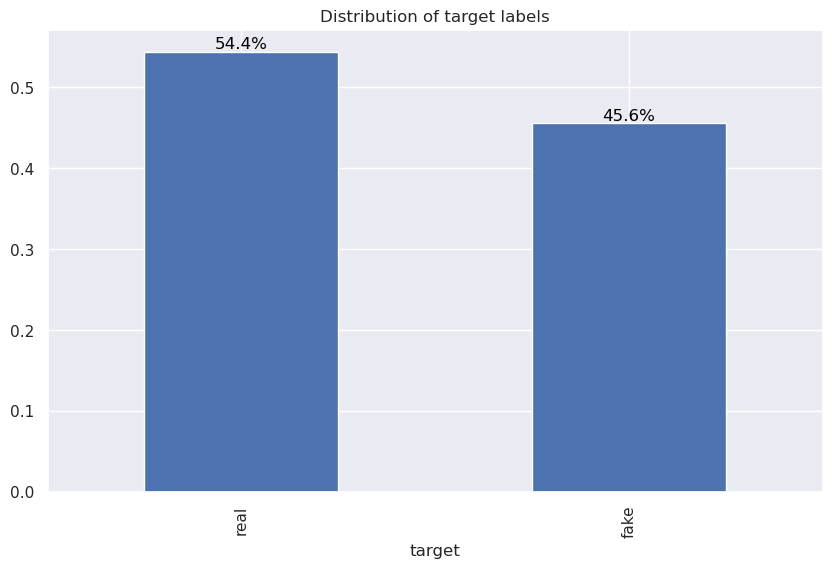

<IPython.core.display.Javascript object>

In [19]:
percentage = df_prep.target.map(map_target)
percentage = percentage.value_counts(normalize=True)
ax = percentage.plot(kind="bar")
for container in ax.containers:
    ax.bar_label(container, padding=0, color="black", fmt="{:.1%}")
ax.set_title("Distribution of target labels")

The distribution is balanced.

Text(0.5, 1.0, 'Distribution of target labels')

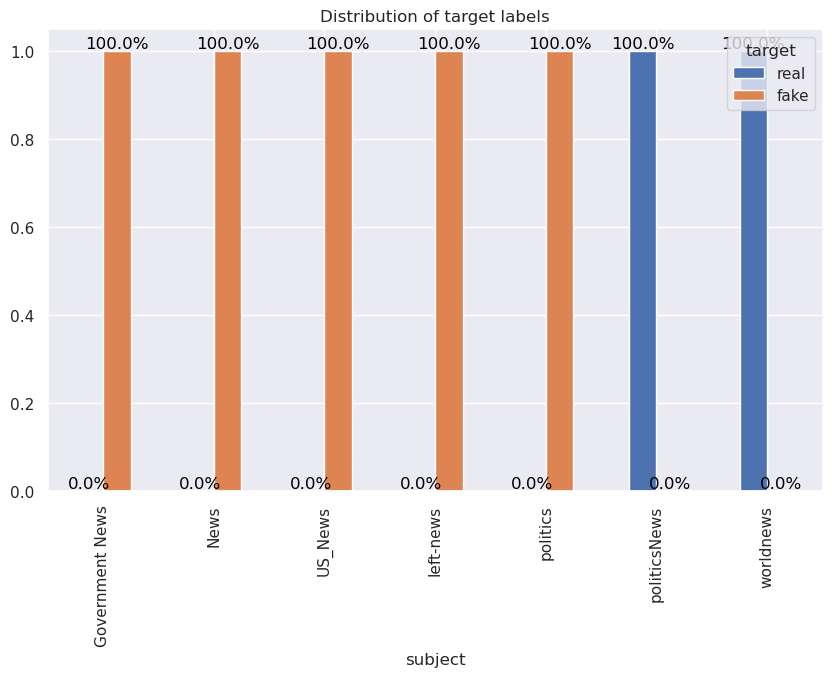

<IPython.core.display.Javascript object>

In [20]:
grouped_df = df_prep.groupby("subject")["target"].value_counts(normalize=True).unstack()
grouped_df.columns = grouped_df.columns.map(map_target)
ax = grouped_df.plot(kind="bar")
for container in ax.containers:
    ax.bar_label(container, padding=0, color="black", fmt="{:.1%}")
ax.set_title("Distribution of target labels")

The target labels have different subject categories. All real news are in the categories politicsNews and worldNews. The subject data is hence ignored from the analysis as it would give misleadingly high accuracy for the models.

In [21]:
df_prep = df_prep.drop(columns="subject")

<IPython.core.display.Javascript object>

In [22]:
num_samples = 3
for label in df_prep["target"].unique():
    print(f"Label: {map_target[label]}")
    group = df_prep.loc[df_prep["target"] == label]
    random_indices = np.random.choice(len(group), size=num_samples, replace=False)
    random_samples = group.iloc[random_indices]

    for sample_title, sample_text in zip(
        random_samples["title"], random_samples["text"]
    ):
        sample_title = sample_title.strip()
        sample_text = sample_text.strip()
        print("Title: " + sample_title[:150])
        print("Text: " + sample_text[:150])
        print("-" * 40)

Label: fake
Title: Sanders Personally Calling Dem Senators Promising Them Party Unity
Text: As the Democratic Primary devolves into tense moments reeling from violent and threatening outbursts stemming from the Nevada Democratic Convention qu
----------------------------------------
Title: Finger in Every Pie How CIA Produces Our News and Entertainment
Text: Century Wire says In so many respects our media is not our ownIn the past  has detailed various aspects of Operation Mockingbird and other CIArelated 
----------------------------------------
Title: Hillary Throws The PERFECT Amount Of Shade At Trump In YearEnd Message
Text: Despite having to deal with an absolute imbecile as her challenger for several months Hillary Clinton was always poised gracious and respectful during
----------------------------------------
Label: real
Title: Obama says transgender rule is important aid to schools BuzzFeed
Text: WASHINGTON Reuters President Barack Obama said on Monday that his administration 

<IPython.core.display.Javascript object>

Here are a random sample of the comments. 

### 2.2 Text properties

Next, news titles and content are investigated more closely.

#### 2.2.1 Title and text word counts

In [23]:
df_prep["text_word_count"] = df_prep["text"].apply(
    lambda x: preprocessingtools.count_words(x)
)
df_prep["title_word_count"] = df_prep["title"].apply(
    lambda x: preprocessingtools.count_words(x)
)

<IPython.core.display.Javascript object>

In [24]:
df_prep[(df_prep.text_word_count == 0)][["title", "text"]]

title  \
9358                                                                                                                                                    
10923                                                               TAKE OUR POLL Who Do You Think President Trump Should Pick To Replace James Comey   
11251                              MELANIA TRUMP GIVES POWERFUL SPEECH to Honor International Women of Courage …Promply Attacked By Lefty Women Video   
11286                                                                  TERRORISM EXPERT SEBASTIAN GORKA On What Next After London Terror Attack Video   
11288                                                   TRUMP CABINET MEMBER MICK MULVANEY ON DC This place is much more rotten than we thought Video   
11315                                                                       CRYBABY NANCY PELOSI Taunts Trump On Healthcare Bill Rookie Mistake Video   
11316  SARA CARTER AND JAY SEKULOW With The Latest On Obama Spying On Trump I think this goes to the highest levels of the Obama administration Video   
11328                                                   SARA CARTER WAS RIGHT ABOUT SPYING ON TRUMP This goes far beyond what is being reported VIDEO   
11387         LIBERAL BIGOT Destroyed by Legendary Democrat Alan Dershowitz in Discussion on Trump s Travel Ban You re lying through your teeth Video   
11433                                           JUDGE JEANINE PIRRO S TRUTH BOMB On Fired US Attorney You were fired by President Trump so what Video   
11492                                                                                             Judge Jeanine Gets to The Bottom of Towergate Video   
11513                 NEWT GINGRICH Punches Back At Democrats With Mega Doses Of TRUTH On The BOGUS Russia Scandal This is a cultural civil war Video   
11548                            FULL INTERVIEW PRESIDENT TRUMP Nails It On Immigration Obamacare US Military Jobs And Incompetent Nancy Pelosi Video   
11570                                                                           WOW TUCKER AND JESSE Destroy The Liberal Kooks Protesting Trump Video   
11626                                                          BOOM TOMI LARHEN Destroys The Idiotic Day Without Immigrants A load of horsecrap Video   
11660                                                               TOMI LAHREN Blasts The Left For Attacking Trump s Grandson…Yes his GRANDSON Video   
11689                                                                   GOTCHA CNN PANELIST Called Out For Lying About Terror Attacks In The US Video   
11695                        TUCKER CARLSON Outs Human Rights Exec Director As A Partisan Hack Obviously partisan motives diminish your mission Video   
11712                                               WATCH Huge Crowd Of Muslims Admit That ALL Muslims Should Be Considered Extremists …Any Questions   
11724                                                   Half my family is here illegally…State Senator Wants Entire State to Be Sanctuary State Video   
11730                                    Fck Trump Fck White People LEFTY GOES NUTS On Judge Jeanine…Proves She s Clueless On Freedom Of Speech Video   
11736                                                             RADICAL DIRECTOR OF SIERRA CLUB Abortion is the key to sustainable population Video   
11794                                                   FOOTBALL LEGEND JIM KELLY Donald Trump took care of my whole family during cancer scare Video   
11804                                          PRESIDENT TRUMP Calls Out Media For Ignoring ProLife March They say the press doesn t cover them Video   
11828                                         WOW CHUCK TODD Goes After Nasty Chuck Schumer Opposition To Trump Nominee Looks Politically Petty Video   
11840               THANK YOU BABY …YES FEMINISTS WILL GO NUTS President Trump Uses Endearment To Refer to Kellyanne Conway In Thank You Speech Video   
11882        

<IPython.core.display.Javascript object>

In [25]:
df_prep[(df_prep.title_word_count == 0)][["title", "text"]]

title text
9358            
15507           
15508           
15839           
15840

<IPython.core.display.Javascript object>

There are instances that have zero length titles or texts.

In [26]:
df_prep.drop(index=df_prep[(df_prep.text_word_count == 0)].index, inplace=True)
df_prep.drop(index=df_prep[(df_prep.title_word_count == 0)].index, inplace=True)

<IPython.core.display.Javascript object>

These instances are removed from the dataset.

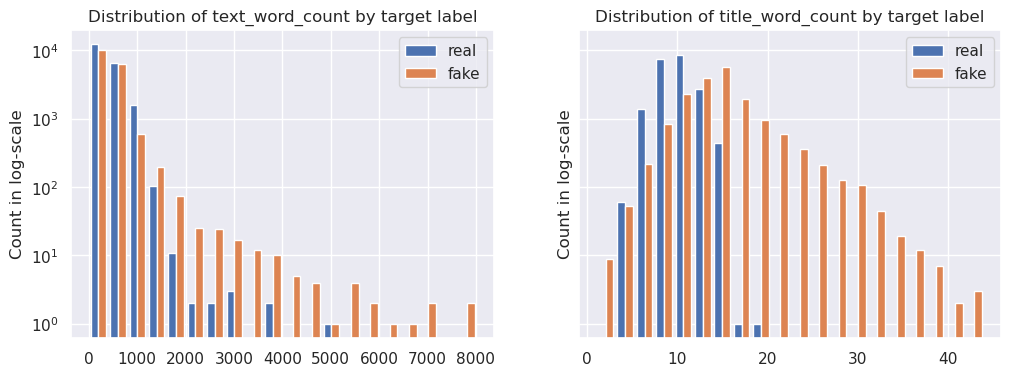

<IPython.core.display.Javascript object>

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, column in zip(axes.flatten(), ["text_word_count", "title_word_count"]):
    ax.set_title(f"Distribution of {column} by target label")
    data_to_plot = []
    for label in map_target.keys():
        label_data = df_prep[df_prep["target"] == label]
        data_to_plot.append(label_data[column])

    ax.hist(
        data_to_plot,
        bins=20,
        histtype="bar",
        label=list(map_target.values()),
    )
    ax.set_yscale("log")
    ax.set_ylabel("Count in log-scale")
    ax.legend().set_visible(True)

It seems that the fake news are generally longer and have longer titles. News with text longer than 5210 words or titles longer than 20 words are all classified as fake news.

In [28]:
df_prep[df_prep["text_word_count"] > 5210]["target"].value_counts()

target
1    12
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [29]:
df_prep[df_prep["title_word_count"] > 20]["target"].value_counts()

target
1    1490
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [30]:
df_prep.groupby("target", as_index=False)["text_word_count"].agg(
    {
        "mean_word_count": "mean",
        "median_word_count": "median",
        "std_word_count": "std",
        "max_word_count": "max",
    }
)

target  mean_word_count  median_word_count  std_word_count  max_word_count
0       0       379.374284              354.0      269.921167            5210
1       1       419.630735              372.0      348.779419            8020

<IPython.core.display.Javascript object>

In [31]:
df_prep.groupby("target", as_index=False)["title_word_count"].agg(
    {
        "mean_word_count": "mean",
        "median_word_count": "median",
        "std_word_count": "std",
        "max_word_count": "max",
    }
)

target  mean_word_count  median_word_count  std_word_count  max_word_count
0       0         9.845232               10.0        1.680008              20
1       1        14.711165               14.0        4.221099              44

<IPython.core.display.Javascript object>

Similar findings are made when the mean, median, and max word counts are compared. Also the deviation of word count is higher for fake news.

#### 2.2.2 Most common words in text

Here the most frequent words in the text are analysed

In [32]:
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jaakoiv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<IPython.core.display.Javascript object>

In [33]:
word_dicts = {}

for label in df_prep["target"].unique():
    sample_df = df_prep[df_prep["target"] == label]
    tokenized_text = [
        nltk.tokenize.word_tokenize(sentence.lower()) for sentence in sample_df["text"]
    ]

    unique_words = [set(inner_list) for inner_list in tokenized_text]
    filtered_nonstop_words = [
        word
        for unique_set in unique_words
        for word in unique_set
        if word not in stopwords
    ]
    stop_words = [
        word for sentence in tokenized_text for word in sentence if word in stopwords
    ]
    non_stop_words = [
        word
        for sentence in tokenized_text
        for word in sentence
        if word not in stopwords
    ]

    word_dicts[label] = {
        "stop_words": nltk.probability.FreqDist(stop_words),
        "nonstop_words": nltk.probability.FreqDist(non_stop_words),
        "uniq_nonstop": nltk.probability.FreqDist(filtered_nonstop_words),
    }

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Distribution of top 10 non-stopword counts in text')

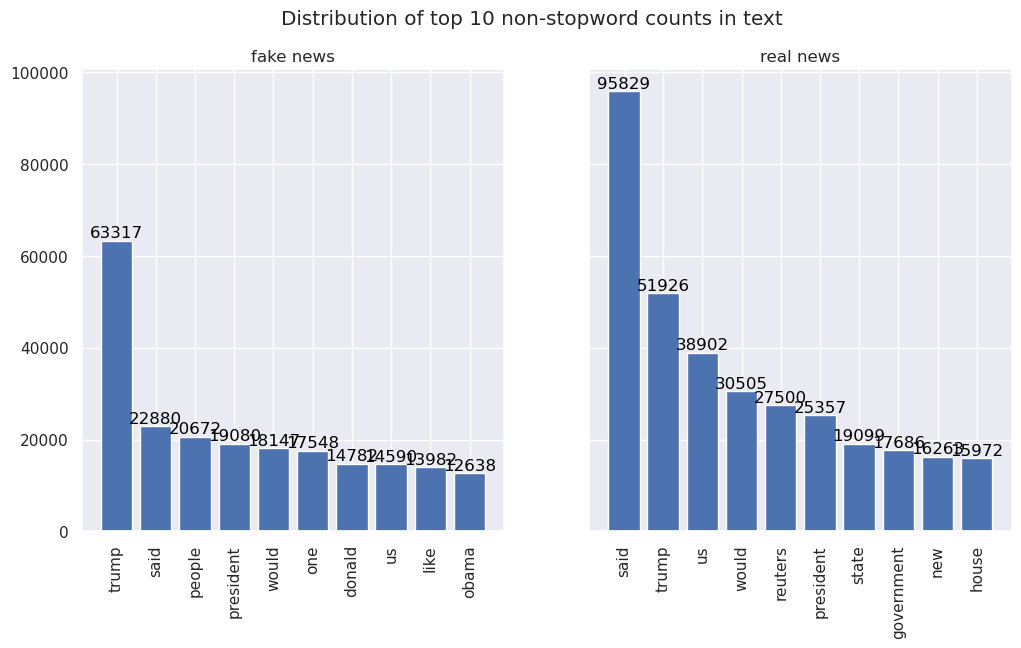

<IPython.core.display.Javascript object>

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for ax, label in zip(axes.flatten(), df_prep["target"].unique()):
    top = word_dicts[label]["nonstop_words"].most_common(10)
    x, y = zip(*top)
    ax.bar(x, y)
    for container in ax.containers:
        ax.bar_label(container, padding=0, color="black", fmt="{:.0f}")
    ax.set_title(f"{map_target[label]} news")
    ax.tick_params(axis="x", rotation=90)
fig.suptitle("Distribution of top 10 non-stopword counts in text")

Here are the top 10 most frequent non-stopwords in 'text' column. There are some deviation between the groups but not much.

For better generalization, the most frequent word from both labels is removed.

In [35]:
df_prep["text"] = df_prep["text"].replace("(?i)(trump)", "", regex=True)
df_prep["text"] = df_prep["text"].replace("(?i)(said)", "", regex=True)

<IPython.core.display.Javascript object>

Then the most common words that appear at least once in the text are identified.

Text(0.5, 0.98, 'Proportion of text containing most common nonstop words')

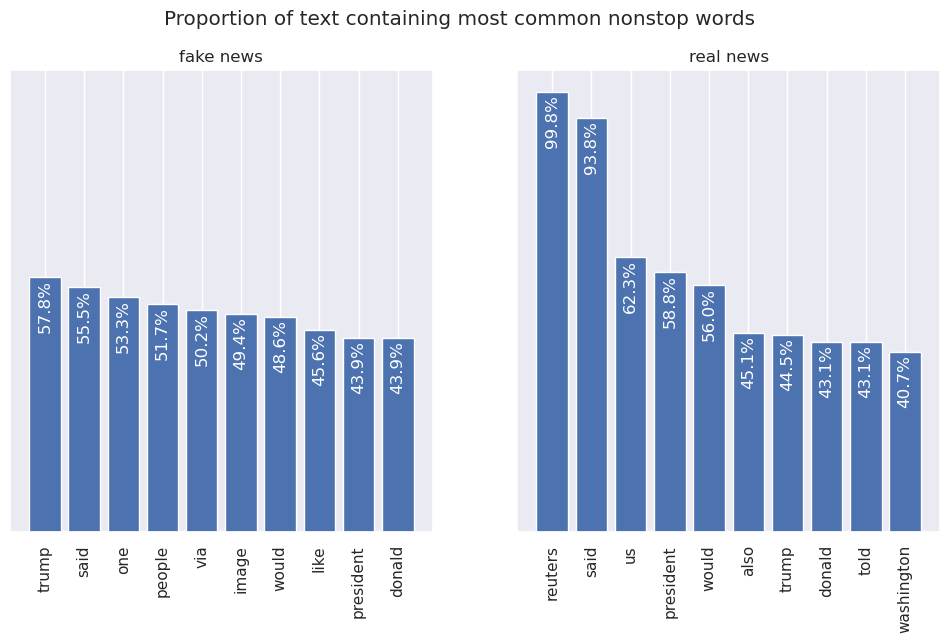

<IPython.core.display.Javascript object>

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for ax, label in zip(axes.flatten(), df_prep["target"].unique()):
    top = word_dicts[label]["uniq_nonstop"].most_common(10)
    x, y = zip(*top)
    y = y / (df_prep["target"] == label).sum()
    ax.bar(x, y)
    for container in ax.containers:
        ax.bar_label(
            container,
            padding=-40,
            color="white",
            fmt="{:.1%}",
            fontsize=12,
            rotation=90,
        )
    ax.set_title(f"{map_target[label]} news")
    ax.set_yticks([])
    ax.tick_params(axis="x", rotation=90)
fig.suptitle("Proportion of text containing most common nonstop words")

From the results it is clearly seen that almost all real news text contain the word 'reuters'. In fake news is much less frequently seen. This can lead to misleadingly high accuracy for the model, and hence, this word is removed from the data.

In [37]:
df_prep.loc[df_prep["target"] == 0, ["text"]].head()

text
0  WASHINGTON Reuters The head of a conservative Republican faction in the US Congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on Sunday and urged budget restraint in  In keeping with a sharp pivot under way among Repub...
1  WASHINGTON Reuters Transgender people will be allowed for the first time to enlist in the US military starting on Monday as ordered by federal courts the Pentagon  on Friday after President Donald  s administration decided not to appeal rulings that blocked his transgender ban Two federal appeal...
2  WASHINGTON Reuters The special counsel investigation of links between Russia and President  s  election campaign should continue without interference in  despite calls from some  administration allies and Republican lawmakers to shut it down a prominent Republican senator  on Sunday Lindsey Grah...
3  WASHINGTON Reuters  campaign adviser George Papadopoulos told an Australian diplomat in May  that Russia had political dirt on Democratic presidential candidate Hillary Clinton the New York Times reported on Saturday The conversation between Papadopoulos and the diplomat Alexander Downer in Lond...
4  SEATTLEWASHINGTON Reuters President Donald  called on the US Postal Service on Friday to charge much more to ship packages for Amazon AMZNO picking another fight with an online retail giant he has criticized in the past Why is the United States Post Office which is losing many billions of dollar...

<IPython.core.display.Javascript object>

If the beginning of the real news articles is looked more closely, the reuters tag is preceded with a location that is typed using uppercase. This kind of pattern in the articles can be considered as a data leakage as the model will learn to classify articles based on these tags rather than actually identifying fake and real news. Therefore, the 'reuters' tag and all preceding text is removed from the articles.

In [38]:
df_prep = df_prep.assign(
    text=df_prep.text.apply(lambda x: preprocessingtools.drop_prefix(x, "reuters"))
)
df_prep["text"] = df_prep["text"].replace("(?i)(reuters)", "", regex=True)

<IPython.core.display.Javascript object>

In [39]:
df_prep.loc[df_prep["target"] == 0, ["text"]].head()

text
0  The head of a conservative Republican faction in the US Congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on Sunday and urged budget restraint in  In keeping with a sharp pivot under way among Republicans US Represent...
1  Transgender people will be allowed for the first time to enlist in the US military starting on Monday as ordered by federal courts the Pentagon  on Friday after President Donald  s administration decided not to appeal rulings that blocked his transgender ban Two federal appeals courts one in Was...
2  The special counsel investigation of links between Russia and President  s  election campaign should continue without interference in  despite calls from some  administration allies and Republican lawmakers to shut it down a prominent Republican senator  on Sunday Lindsey Graham who serves on th...
3  campaign adviser George Papadopoulos told an Australian diplomat in May  that Russia had political dirt on Democratic presidential candidate Hillary Clinton the New York Times reported on Saturday The conversation between Papadopoulos and the diplomat Alexander Downer in London was a driving fac...
4  President Donald  called on the US Postal Service on Friday to charge much more to ship packages for Amazon AMZNO picking another fight with an online retail giant he has criticized in the past Why is the United States Post Office which is losing many billions of dollars a year while charging Am...

<IPython.core.display.Javascript object>

#### 2.2.3 Ngrams in text

Next, word pairs and sequences in the text for each target label are investigated.

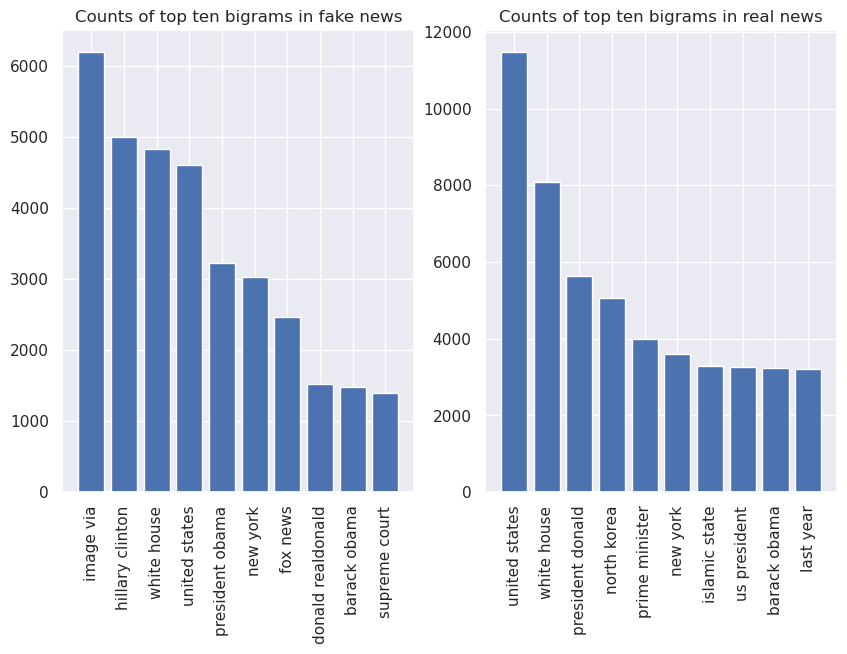

<IPython.core.display.Javascript object>

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
for ax, label in zip(axes.flatten(), df_prep["target"].unique()):
    label_data = df_prep[df_prep["target"] == label]
    top_bigrams = preprocessingtools.get_top_ngram(
        label_data["text"], 2, stopwords=list(stopwords)
    )
    x, y = map(list, zip(*top_bigrams))
    ax.bar(x, y)
    ax.set_title(f"Counts of top ten bigrams in {map_target[label]} news")
    ax.tick_params("x", labelrotation=90)

The top ten bigrams are presented here. There is weird bigram 'image via' which could be a data leakage. It could be that in fake news outside image services are used more often and this could be the reason why this bigram is seen regularly.

In [41]:
print(
    f"Real news occurances: {df_prep.loc[df_prep['target']==0, 'text'].str.contains('image via').sum()}"
)
print(
    f"Fake news occurances: {df_prep.loc[df_prep['target']==1, 'text'].str.contains('image via').sum()}"
)

Real news occurances: 0
Fake news occurances: 6061


<IPython.core.display.Javascript object>

It seems that it occurs only in fake news.

In [42]:
df_sample = df_prep[df_prep["text"].str.contains("image via")].sample(10)
pattern = r"(.{0,75}\bimage\s+via\b.{0,75})"
matches = df_sample["text"].str.extract(pattern, flags=re.IGNORECASE)

print(matches)

                                                                                                                             0
8676              t by their government against the sort of hate that  peddles dailyfeatured image via fox news screen capture
7030                           h a view to pressing chimerical charges against those responsible Featured image via Screengrab
8786                                Ryan s failed attempt to stifle his laugh begins almost immediatelyyoutube image via CSPAN
1589                t hood you know he owns in public He s not even pretending anymoreFeatured image via Alex WongGetty Images
7552                       y participate again is something every Democrat can take pride in Featured image via Chelsea Skojec
1048            ty clearly reached a breaking point and  only has himself to blameFeatured image via Spencer PlattGetty Images
4868  nthewool bona fide racist elected as president Watch Pence s remarks below image via Ty WrightBloomberg v

<IPython.core.display.Javascript object>

However, as it is not that frequent, it is left to the data.

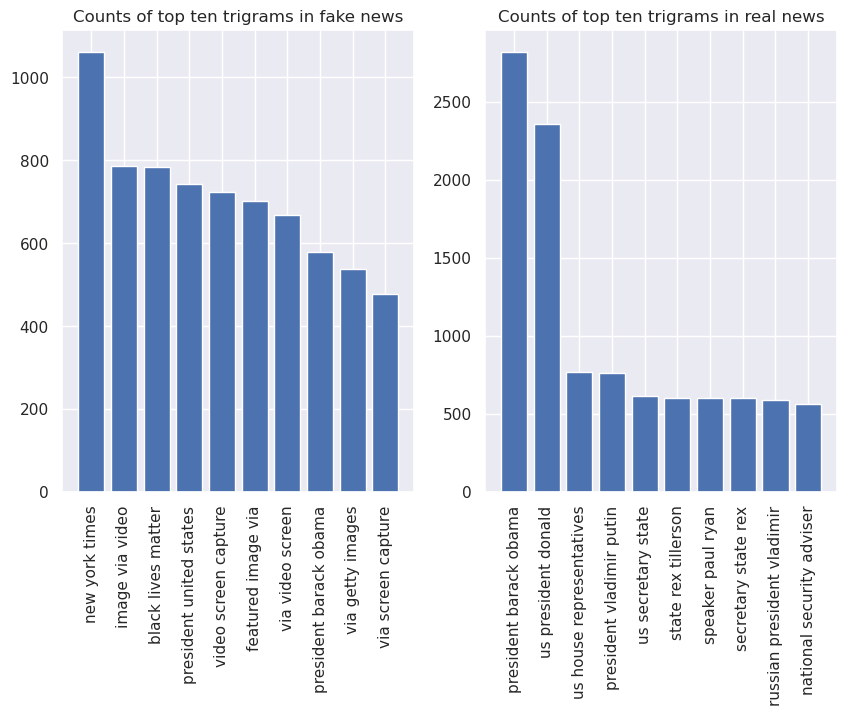

<IPython.core.display.Javascript object>

In [43]:
fig, axes = plt.subplots(1, 2)
for ax, label in zip(axes.flatten(), df_prep["target"].unique()):
    label_data = df_prep[df_prep["target"] == label]
    top_bigrams = preprocessingtools.get_top_ngram(
        label_data["text"], 3, stopwords=list(stopwords)
    )
    x, y = map(list, zip(*top_bigrams))
    ax.bar(x, y)
    ax.set_title(f"Counts of top ten trigrams in {map_target[label]} news")
    ax.tick_params("x", labelrotation=90)

The top ten trigrams are presented here. There are similarities between the target labels, but also the different image and video sources are in the top trigrams of the fake news. 

#### 2.2.4 Most common words in titles

Next, similar analysis is conducted for the titles.

In [44]:
title_word_dicts = {}

for label in df_prep["target"].unique():
    sample_df = df_prep[df_prep["target"] == label]
    tokenized_text = [
        nltk.tokenize.word_tokenize(sentence.lower()) for sentence in sample_df["title"]
    ]

    unique_words = [set(inner_list) for inner_list in tokenized_text]
    filtered_nonstop_words = [
        word
        for unique_set in unique_words
        for word in unique_set
        if word not in stopwords
    ]
    stop_words = [
        word for sentence in tokenized_text for word in sentence if word in stopwords
    ]
    non_stop_words = [
        word
        for sentence in tokenized_text
        for word in sentence
        if word not in stopwords
    ]

    title_word_dicts[label] = {
        "stop_words": nltk.probability.FreqDist(stop_words),
        "nonstop_words": nltk.probability.FreqDist(non_stop_words),
        "uniq_nonstop": nltk.probability.FreqDist(filtered_nonstop_words),
    }

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Distribution of top 10 non-stopword counts in titles')

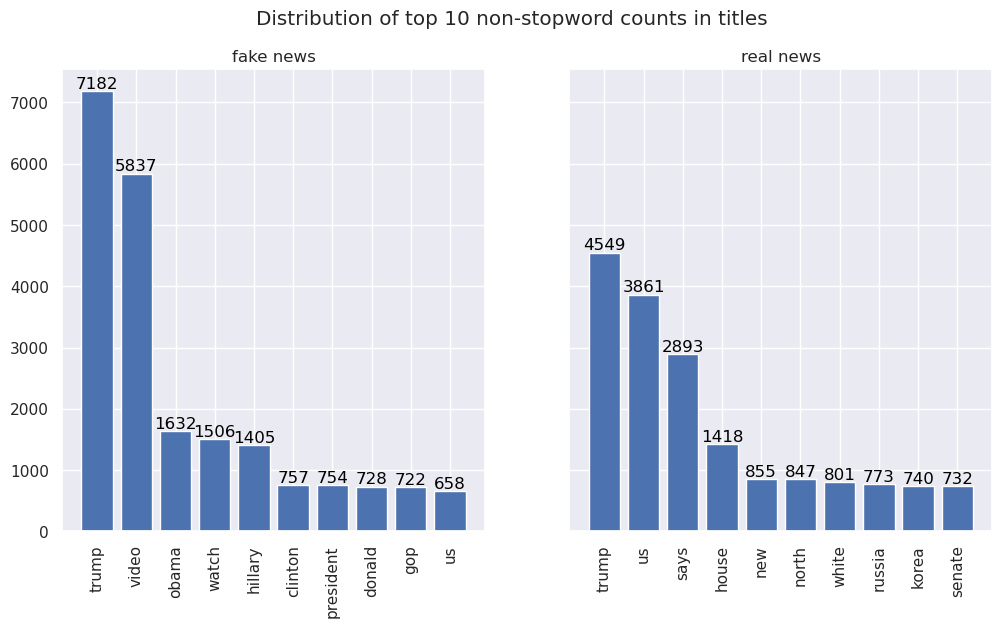

<IPython.core.display.Javascript object>

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for ax, label in zip(axes.flatten(), df_prep["target"].unique()):
    top = title_word_dicts[label]["nonstop_words"].most_common(10)
    x, y = zip(*top)
    ax.bar(x, y)
    for container in ax.containers:
        ax.bar_label(container, padding=0, color="black", fmt="{:.0f}")
    ax.set_title(f"{map_target[label]} news")
    ax.tick_params(axis="x", rotation=90)
fig.suptitle("Distribution of top 10 non-stopword counts in titles")

Here are the top 10 most frequent non-stopwords in titles. There are some deviation between the groups. Trump is the most common word for both classes.

Here also the most frequent word from both target labels are removed.

In [46]:
df_prep["title"] = df_prep["title"].replace("(?i)(trump)", "", regex=True)

<IPython.core.display.Javascript object>

Then the most common words that appear at least once in the titles are identified.

Text(0.5, 0.98, 'Proportion of titles containing most common nonstop words')

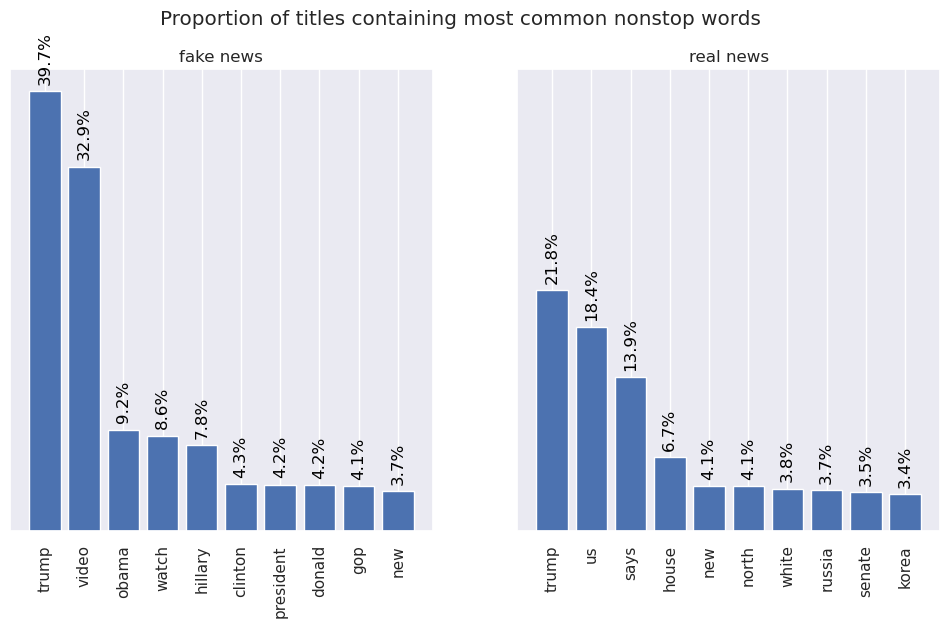

<IPython.core.display.Javascript object>

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for ax, label in zip(axes.flatten(), df_prep["target"].unique()):
    top = title_word_dicts[label]["uniq_nonstop"].most_common(10)
    x, y = zip(*top)
    y = y / (df_prep["target"] == label).sum()
    ax.bar(x, y)
    for container in ax.containers:
        ax.bar_label(
            container, padding=5, color="black", fmt="{:.1%}", fontsize=12, rotation=90
        )
    ax.set_title(f"{map_target[label]} news")
    ax.set_yticks([])
    ax.tick_params(axis="x", rotation=90)
fig.suptitle("Proportion of titles containing most common nonstop words")

Again here 'trump' is the most commonly occurring word in titles.

#### 2.2.5 Letter case

Next, the letter case in titles and text are investigated. First, the frequence of uppercase words is calculated.

In [48]:
title_uppercase = (
    df_prep.groupby("target")["title"]
    .apply(lambda x: x.apply(preprocessingtools.uppercase_counter))
    .reset_index(name="uppercase_counter")
)
text_uppercase = (
    df_prep.groupby("target")["text"]
    .apply(lambda x: x.apply(preprocessingtools.uppercase_counter))
    .reset_index(name="uppercase_counter")
)

<IPython.core.display.Javascript object>

In [49]:
title_uppercase.groupby("target")["uppercase_counter"].sum()

target
0     7889
1    50163
Name: uppercase_counter, dtype: int64

<IPython.core.display.Javascript object>

In [50]:
text_uppercase.groupby("target")["uppercase_counter"].sum()

target
0    117339
1    142538
Name: uppercase_counter, dtype: int64

<IPython.core.display.Javascript object>

It seems that there are uppercase words in both target labels. However, in titles the difference is much larger.

Next, the appearance of uppercase word in title or text is investigated.

In [51]:
title_uppercase["has_uppercase"] = title_uppercase["uppercase_counter"] > 0
text_uppercase["has_uppercase"] = text_uppercase["uppercase_counter"] > 0

<IPython.core.display.Javascript object>

In [52]:
title_uppercase.groupby("target")["has_uppercase"].sum() / df_prep.shape[0]

target
0    0.183667
1    0.388372
Name: has_uppercase, dtype: float64

<IPython.core.display.Javascript object>

Results show that almost 40% of fake news titles have uppercase words. In real news the proportion is only around 18%. Let's define this as a new feature into the dataframe.

In [53]:
df_prep["title_uppercase_count"] = df_prep["title"].apply(
    preprocessingtools.uppercase_counter
)

<IPython.core.display.Javascript object>

In [54]:
text_uppercase.groupby("target")["has_uppercase"].sum() / df_prep.shape[0]

target
0    0.489638
1    0.421516
Name: has_uppercase, dtype: float64

<IPython.core.display.Javascript object>

In article texts the proportions are more close to each other and it is not considered as important feature.

### 2.3 Dates

Here, the dates of the news are studied more closely.

In [55]:
real_dates = (
    pd.to_datetime(df_prep.loc[df_prep["target"] == 0, "date"], errors="coerce")
    .value_counts()
    .sort_index()
)
fake_dates = (
    pd.to_datetime(df_prep.loc[df_prep["target"] == 1, "date"], errors="coerce")
    .value_counts()
    .sort_index()
)

<IPython.core.display.Javascript object>

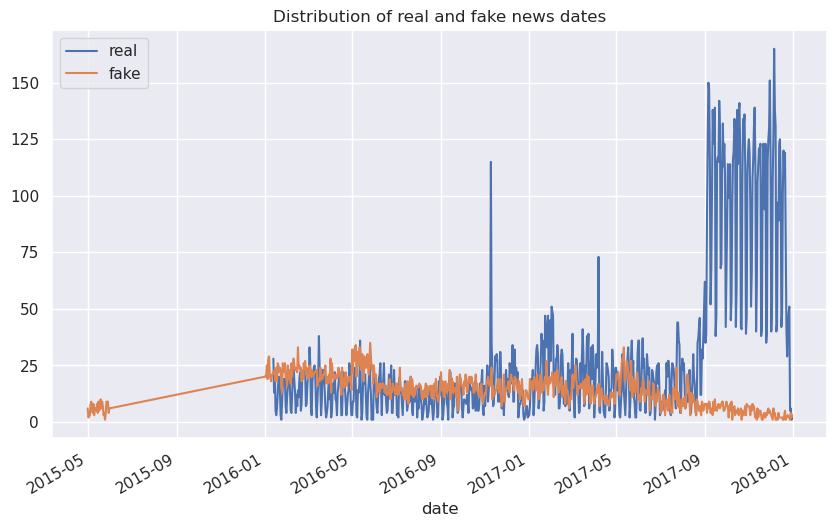

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots()
real_dates.plot(ax=ax, label="real")
fake_dates.plot(ax=ax, label="fake")
ax.set_title("Distribution of real and fake news dates")
ax.legend()

From the time history, it is seen that all real news data in the dataset is dated after 2016. This may result in a misleadingly high model accuracy. It is assumed that the date information is not a key predictor in the real/fake news classification and it can be neglected from the model training completely. Moreover, part of the data is missing correct date information. 

In [57]:
df_prep = df_prep.drop(columns="date")

<IPython.core.display.Javascript object>

## 3. Model training

Here the model training is conducted. First, a heuristic rule-based model is created to set a base score on which other models are compared. Then three different machine learning models are trained, and finally, a neural network model is trained. 

The data is split into train, validation, and test set. For both validation and test set, 15% of the data is used. Rest is used in training. The model performances are compared against validation data and the performance of the best model is finally assessed with test data.

ROC AUC metric will be used for the comparison of the more complex models, as ROC AUC value describes better the models ability to separate the target labels without the need of conducting probability threshold optimization. However, because the ROC AUC value can not be calculated for the rule-based model, the metric used in the comparison against the base score will be macro f1 score. This metric considers the small difference is the target label distribution and describes the model ability to classify the target labels.


In [58]:
df_model = df_prep.copy()

<IPython.core.display.Javascript object>

In [59]:
df_train, df_test = train_test_split(
    df_model, test_size=0.3, stratify=df_model["target"]
)
df_test, df_val = train_test_split(df_test, test_size=0.5, stratify=df_test["target"])

<IPython.core.display.Javascript object>

In [60]:
X_train = df_train.drop(columns="target")
X_val = df_val.drop(columns="target")
X_test = df_test.drop(columns="target")
y_train = df_train["target"].copy()
y_val = df_val["target"].copy()
y_test = df_test["target"].copy()

<IPython.core.display.Javascript object>

### 3.1 Heuristic rule

First, a heuristic rule-based model is used to define the base score for this project. Based on EDA, the word counts of titles and text are used together with letter casing to determine if the news article is fake or real news. In addition, if the article contains bigram 'image via' it is labeled as fake news.

In [61]:
def heuristic_model(row):
    """Heuristic model to classify real and fake news."""
    title = row["title"]
    text = row["text"]
    title_w_count = preprocessingtools.count_words(title)
    if title_w_count > 20:
        return 1
    text_w_count = preprocessingtools.count_words(text)
    if text_w_count > 5210:
        return 1
    if "image via" in text:
        return 1

    count_uppercase_words = preprocessingtools.uppercase_counter(title)
    if count_uppercase_words > 0:
        return 1
    else:
        return 0

<IPython.core.display.Javascript object>

In [62]:
df_train["predicted"] = df_train.apply(heuristic_model, axis=1)
df_val["predicted"] = df_val.apply(heuristic_model, axis=1)

<IPython.core.display.Javascript object>

In [63]:
postprocessingtools.metrics(
    df_train["target"], df_train["predicted"], label_names=["real", "fake"]
)

              precision    recall  f1-score   support

        real     0.9188    0.6634    0.7705     14541
        fake     0.6982    0.9300    0.7976     12175

    accuracy                         0.7849     26716
   macro avg     0.8085    0.7967    0.7840     26716
weighted avg     0.8183    0.7849    0.7828     26716



<IPython.core.display.Javascript object>

Training dataset results.

In [64]:
postprocessingtools.metrics(
    df_val["target"], df_val["predicted"], label_names=["real", "fake"]
)

              precision    recall  f1-score   support

        real     0.9217    0.6569    0.7671      3116
        fake     0.6950    0.9333    0.7967      2610

    accuracy                         0.7829      5726
   macro avg     0.8083    0.7951    0.7819      5726
weighted avg     0.8183    0.7829    0.7806      5726



<IPython.core.display.Javascript object>

Validation dataset results. The model performance does not significantly differ between train and validation dataset. This is good indicates good generalization of the model. In addition, the performance exceeds the random chance of 50%. The validation set values will set the base score (macro f1 0.79) for which other models are compared.

### 3.2 Machine learning models

Then three machine learning models are trained for the task. Three different model types are used: first a simple linear model logistic regression, then a random forest model, and finally a gradient decent model CatBoost.

All the new engineered features are used for these models together with vectorized title and text values.

In [65]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    stop_words="english",
    max_features=50,
)

preprocessor_log = ColumnTransformer(
    transformers=[
        ("content", tfidf_vectorizer, "text"),
        ("title", tfidf_vectorizer, "title"),
        (
            "num",
            StandardScaler(),
            ["text_word_count", "title_word_count", "title_uppercase_count"],
        ),
    ],
    remainder="passthrough",
)
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("content", tfidf_vectorizer, "text"),
        ("title", tfidf_vectorizer, "title"),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

The uni-, bi- and trigrams are considered but stopwords are excluded from the text vectorizer. For logistic regression and CatBoost, the numerical values are standardized.

Here the model configurations are presented.

In [66]:
init_models = (
    ("logres", LogisticRegression(random_state=0, C=0.01), preprocessor_log),
    (
        "randomforest",
        RandomForestClassifier(
            random_state=0, n_estimators=100, max_depth=6, min_samples_split=8
        ),
        preprocessor_tree,
    ),
    (
        "catboost",
        cat.CatBoostClassifier(
            task_type="GPU",
            iterations=200,
            loss_function="Logloss",
            early_stopping_rounds=5,
            depth=4,
            l2_leaf_reg=3,
            verbose=200,
        ),
        preprocessor_log,
    ),
)

<IPython.core.display.Javascript object>

Then the models are trained.

In [67]:
models = {}
scores = {}
inference_times = {}
for model_name, model, preprocessor in init_models:
    print("------------------------------------")
    print(model_name)
    (
        models[model_name],
        scores[model_name],
        inference_times[model_name],
    ) = mlmodeltrainer.ml_trainer(
        X_train, y_train, X_val, y_val, model, preprocessor, cv=5
    )

------------------------------------
logres
CV Train scores AUC: [0.9737682231131848, 0.9731939919555482, 0.9728767167537088, 0.9742091419810279, 0.9737876352252168]
Mean CV Train score AUC: 0.9736
CV Validation scores AUC: [0.9713498362018885, 0.9752299822905869, 0.9775685004053112, 0.969656883651698, 0.9722891464175863]
Mean CV Validation score AUC: 0.9732
Validation score AUC: 0.9715
Inference time: 0.00000000 ms
------------------------------------
randomforest
CV Train scores AUC: [0.9833192757217221, 0.9820658667520054, 0.9818694419031324, 0.9835862485660438, 0.9826451417769776]
Mean CV Train score AUC: 0.9827
CV Validation scores AUC: [0.9799405371561598, 0.980794960584552, 0.983273431078749, 0.9806079808162146, 0.979295591853105]
Mean CV Validation score AUC: 0.9808
Validation score AUC: 0.9780
Inference time: 0.00000000 ms
------------------------------------
catboost
0:	learn: 0.6538404	test: 0.6541410	best: 0.6541410 (0)	total: 7.95ms	remaining: 1.58s
199:	learn: 0.1477768	t

<IPython.core.display.Javascript object>

Based on the results the CatBoost Classifier performances the best. For all model the difference between performance across different subsets of data is rather small which indicates good generalization of the models. Moreover, the training and validation scores are close to each other.

In addition, it seems that by removing most frequent words and ngrams the generalization and overfitting of the models has improved from the initial setup.

In [68]:
for model_name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    print("------------------------------------")
    print(model_name)
    postprocessingtools.metrics(
        y_val, y_pred, y_proba=y_proba[:, 1], label_names=["real", "fake"]
    )

------------------------------------
logres
              precision    recall  f1-score   support

        real     0.9033    0.9708    0.9358      3116
        fake     0.9617    0.8759    0.9168      2610

    accuracy                         0.9275      5726
   macro avg     0.9325    0.9233    0.9263      5726
weighted avg     0.9299    0.9275    0.9271      5726

------------------------------------
randomforest
              precision    recall  f1-score   support

        real     0.9132    0.9625    0.9372      3116
        fake     0.9521    0.8908    0.9204      2610

    accuracy                         0.9298      5726
   macro avg     0.9327    0.9266    0.9288      5726
weighted avg     0.9309    0.9298    0.9295      5726

------------------------------------
catboost
              precision    recall  f1-score   support

        real     0.9283    0.9727    0.9500      3116
        fake     0.9655    0.9103    0.9371      2610

    accuracy                         0.944

<IPython.core.display.Javascript object>

When the macro f1 results of the models are compared to the heuristic model, all the models exceed the base score.

In [69]:
for model, metric in scores.items():
    print(f"{model}\tROC AUC: {metric}")

logres	ROC AUC: 0.9714812683517035
randomforest	ROC AUC: 0.9780366074985614
catboost	ROC AUC: 0.9858567694116143


<IPython.core.display.Javascript object>

Based on the ROC AUC values and upper comparison, the CatBoost model performs the best from the ML models and heuristic model.

#### 3.2.1 Feature importance

The performance scores for all the models are extremely high even after removing identified data leakages from the data. It is interesting to see which features are giving highest importance and influence to the classification of data instances.

Next, the feature importance is investigated for all the models. For the logistic regression, the model coefficients are investigated. For the random forest, the model’s own feature important metric for training data is evaluated. Finally for the CatBoost model, the model’s own the feature importance metric for training and validation data is evaluated. 

In [163]:
coefs = models["logres"].named_steps["clf"].coef_[0]
coefs_indx_sorted = np.argsort(coefs)
coefs_sorted = coefs[coefs_indx_sorted]

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Model coefficient distribution')

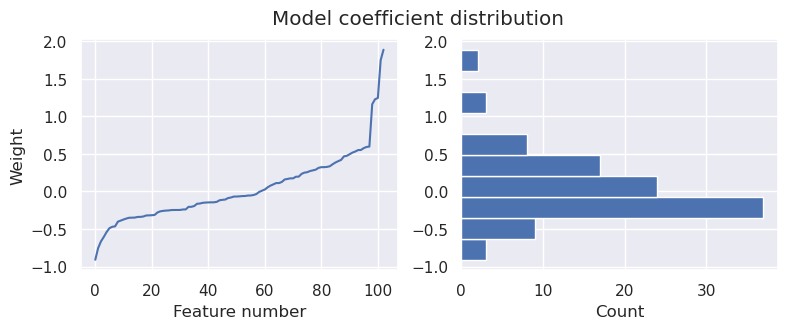

<IPython.core.display.Javascript object>

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))

sns.lineplot(data=coefs_sorted, ax=axs[0])
axs[0].set_ylabel("Weight")
axs[0].set_xlabel("Feature number")
axs[1].hist(coefs_sorted, orientation="horizontal")
axs[1].set_xlabel("Count")
fig.suptitle("Model coefficient distribution")

In [165]:
feat_name = models["logres"].named_steps["preprocessor"].get_feature_names_out()
feat_sorted = np.array(feat_name)[coefs_indx_sorted]

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'The 15 most important coefficients of Logistic regression model')

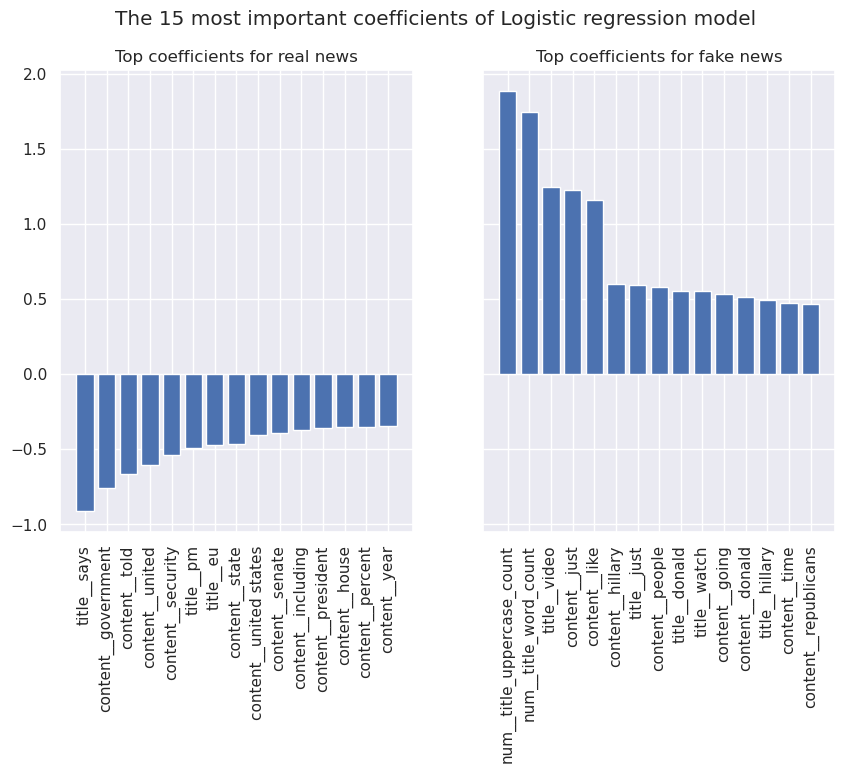

<IPython.core.display.Javascript object>

In [166]:
top_n = 15
fig, axes = plt.subplots(1, 2, sharey=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i == 1:
        ax.bar(
            x=np.flip(feat_sorted[-top_n:]),
            height=np.flip(coefs_sorted[-top_n:]),
        )
    else:
        ax.bar(x=feat_sorted[:top_n], height=coefs_sorted[:top_n])
    ax.set_title(f"Top coefficients for {map_target[i]} news")
    ax.tick_params("x", labelrotation=90)
fig.suptitle(f"The {top_n} most important coefficients of Logistic regression model")

The top features seem reasonable for the classification task. The title uppercase counter, and title length seem to have high importance for classifying the instance to fake news. It seems also that articles about EU seem to be generally real news rather than fake news as acronyms like 'pm' and 'eu' are in the top important features for real news. This could be because of the dataset is concentrated on US politics.

Then the tree model feature importance is investigated.

In [167]:
tree_feat_dict = {}
for col, val in sorted(
    zip(
        models["randomforest"].named_steps["preprocessor"].get_feature_names_out(),
        models["randomforest"].named_steps["clf"].feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
):
    tree_feat_dict[col] = val
feat_tree_df = pd.DataFrame(
    {"Feature": tree_feat_dict.keys(), "Importance": tree_feat_dict.values()}
)
feat_tree_df = feat_tree_df.sort_values(by="Importance", ascending=False)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top 15 most important features of Random Forest model')

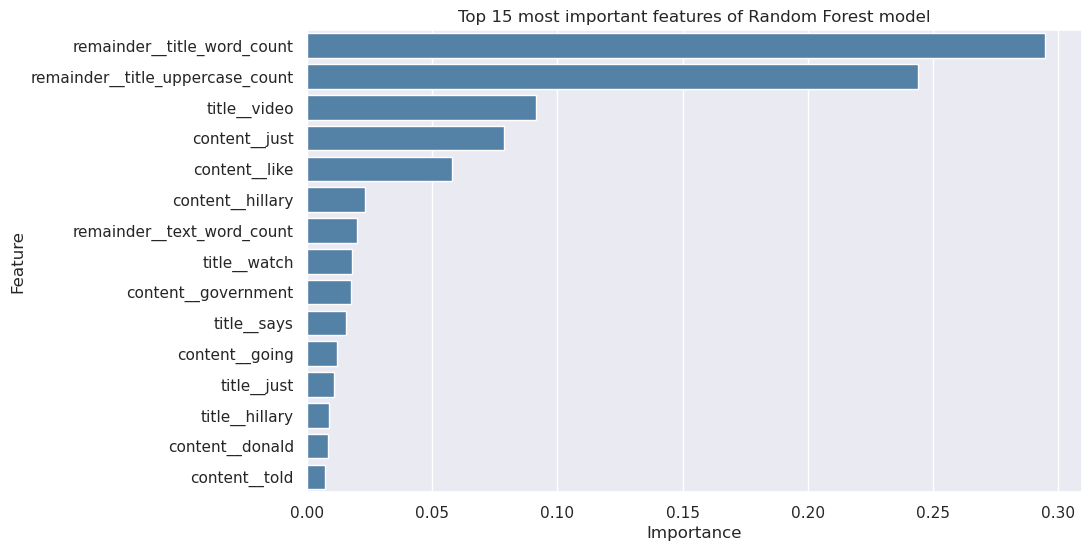

<IPython.core.display.Javascript object>

In [168]:
topn = 15
feat_tree_df = feat_tree_df.iloc[:topn, :]
ax = sns.barplot(
    y=feat_tree_df["Feature"], x=feat_tree_df["Importance"], color="steelblue"
)
ax.set_title(f"Top {topn} most important features of Random Forest model")

Here the title and text length have higher value in the classification of the news. Here we can see similar features appearing the top features, e.g. uppercase counter, title length, title words 'video', 'just', and 'like'. All these values are found also from top important features of logistic regression.

In [169]:
feature_names = models["catboost"].named_steps["preprocessor"].get_feature_names_out()
feature_importance = (
    models["catboost"]
    .named_steps["clf"]
    .get_feature_importance(type="FeatureImportance")
)
feat_cat_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feat_cat_df = feat_cat_df.sort_values(by="Importance", ascending=False)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top 15 most important features of Catboost model')

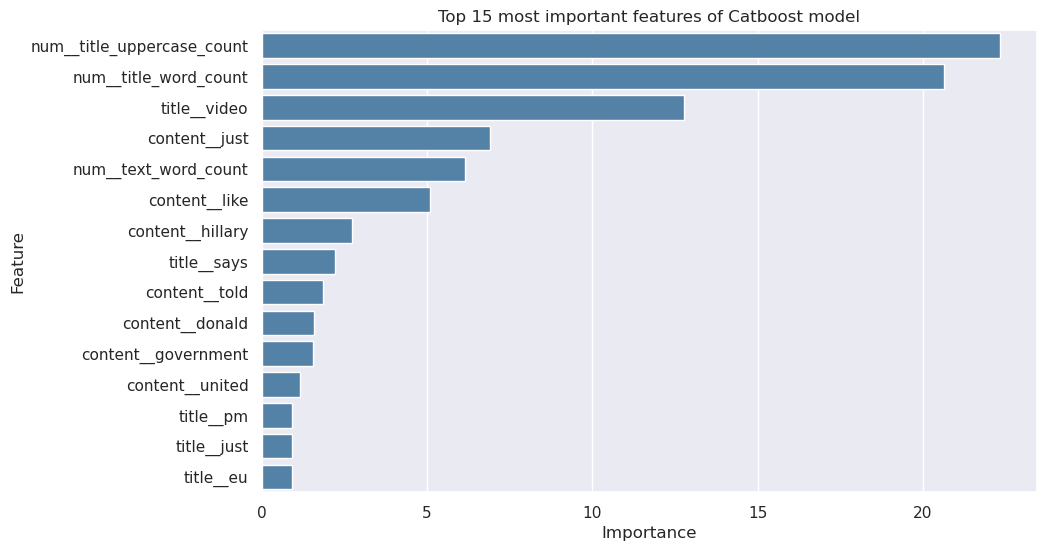

<IPython.core.display.Javascript object>

In [170]:
topn = 15
feat_cat_df = feat_cat_df.iloc[:topn, :]
ax = sns.barplot(
    y=feat_cat_df["Feature"], x=feat_cat_df["Importance"], color="steelblue"
)
ax.set_title(f"Top {topn} most important features of Catboost model")

Here the top features are rather similar for the previous models.  There are some changes in the order but not much.

In [171]:
X_val_trans = preprocessor.transform(X_val)
val_feature_importance = (
    models["catboost"]
    .named_steps["clf"]
    .get_feature_importance(
        cat.Pool(X_val_trans, label=y_val), type="PredictionValuesChange"
    )
)
val_feat_cat_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": val_feature_importance}
)
val_feat_cat_df = val_feat_cat_df.sort_values(by="Importance", ascending=False)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top 15 most important features of Catboost model validation data')

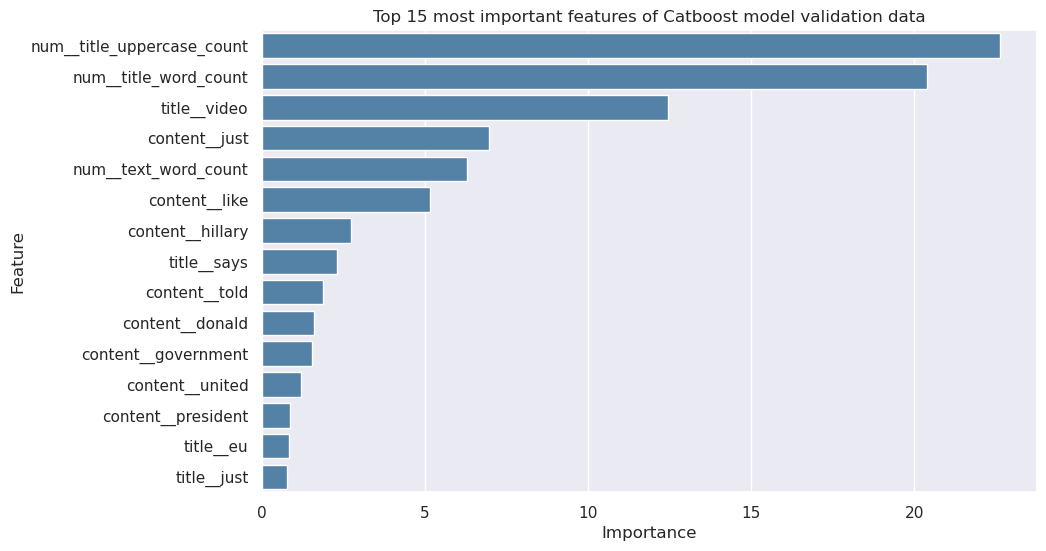

<IPython.core.display.Javascript object>

In [173]:
topn = 15
val_feat_cat_df = val_feat_cat_df.iloc[:topn, :]
ax = sns.barplot(
    y=val_feat_cat_df["Feature"], x=val_feat_cat_df["Importance"], color="steelblue"
)
ax.set_title(f"Top {topn} most important features of Catboost model validation data")

Finally, the feature importance of the validation data. The top features are identical to the previous top features of the training data. Only the last three features are different.  

Based on the identified most important features, all the models identified the similar findings as in EDA, e.g. letter casing, word counts. In addition to that, the models identified that multimedia content in the news article, informative text ‘just’, mention of Donald Trump and Hillary Clinton, and political term e.g. president, pm, or government have high influence on the classification. 

### 3.3 Neural network models

Here neural network models are trained for the classification task. The models have a pre-trained DistilBERT transformer backbones and a separate classifier head. Two different models are trained. For each model first, the classifier head is trained and then the whole model is fine tuned using the recommended  batch size, learning rate and numper of epochs provided by the BERT developers:
- Learning rate between 2e-5 and 5e-5.
- Batch size between 16 and 32.
- Number of epochs between 2 and 4.

The first model has smaller classifier head with 
- fully connected layer,
- dropout layer,
- output layer. 

The second model has deeper architecture for better regularization:
- fully connected layer
- dropout layer,
- fully connected layer,
- activation ReLU,
- dropout layer,
- output layer.

For the NN models, the title and text parts of the news articles are joined together and then tokenized based on the model achitectyre. The max sequence length 128 tokens is selected based on initial testing and GPU memory limitation.

In [174]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

In [79]:
train_dataset = customdataset.CustomNewsDataset(df_train)
validation_dataset = customdataset.CustomNewsDataset(df_val)
test_dataset = customdataset.CustomNewsDataset(df_test)

<IPython.core.display.Javascript object>

#### 3.3.1 DistilBERT

First classifier head training. For the classifier head training, the learning rate is selected with pytorch learning rate finder.

In [80]:
model_nn = modelclass.NewsClassifier(
    train_dataset,
    validation_dataset,
    test_dataset,
    lr=2e-4,
    batch_size=32,
    backbone_tuning=False,
)
model_name = "Distilbert"
version = "clf_training"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [122]:
modeltrainer.train(model_nn, model_name, version, max_epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---Currently Distilbert version clf_training in training.---


/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/Distilbert/clf_training exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jaakoiv/DeepLearning/logs/Distilbert/clf_training/best_ckpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus o

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.00478630092322638
Restoring states from the checkpoint path at /home/jaakoiv/DeepLearning/.lr_find_d4af92a7-0374-48a0-803e-3600dfb38ab8.ckpt
Restored all states from the checkpoint at /home/jaakoiv/DeepLearning/.lr_find_d4af92a7-0374-48a0-803e-3600dfb38ab8.ckpt


---Selected starting learning rate: 0.00478630092322638---


/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jaakoiv/DeepLearning/logs/Distilbert/clf_training/best_ckpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                                | Params
----------------------------------------------------------------------
0 | train_score   | BinaryAUROC                         | 0     
1 | valid_score   | BinaryAUROC                         | 0     
2 | test_score    | BinaryAUROC                         | 0     
3 | model         | DistilBertForSequenceClassification | 67.0 M
4 | loss_function | BCEWithLogitsLoss                   | 0     
----------------------------------------------------------------------
591 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.817   Total estima

Sanity Checking: 0it [00:00, ?it/s]

/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


<IPython.core.display.Javascript object>

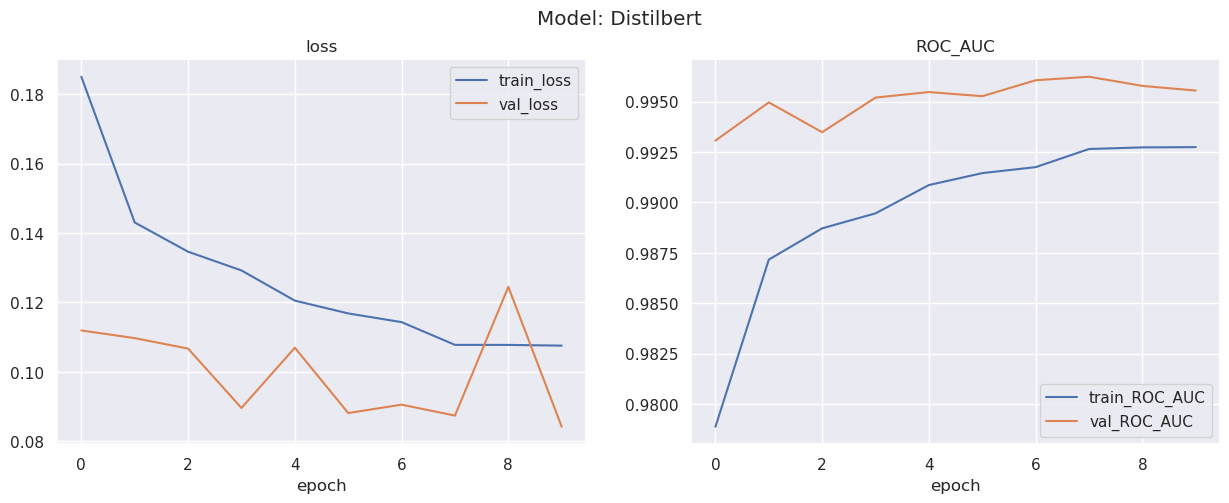

<IPython.core.display.Javascript object>

In [123]:
modeltrainer.plot_metrics(model_name, version, ["loss", "score"], ["loss", "ROC_AUC"])

The validation and training losses are decreasing over epochs so the model is continuously learning from the new data and generalizing well. Moreover, the gap between training and validation ROC AUC values is relatively small which also indicates reasonable generalization.

In [81]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
evaluation_clft = modeltrainer.evaluate(model_nn, model_name, validation_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [82]:
evaluation_clft["metrics"]

ROC AUC  Average Inference Time
model                                       
Distilbert  0.996955                0.044962

<IPython.core.display.Javascript object>

Next the backbone is unfreeze and fine-tuned together with the classifier head.

In [126]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

In [83]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
model_nn.lr = 2e-5
model_nn.backbone_tuning = True
model_nn._base_grad(True, True)
model_name = "Distilbert"
version = "fine_tuning"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [128]:
modeltrainer.train(model_nn, model_name, version, max_epochs=10, lr=model_nn.lr)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---Currently Distilbert version fine_tuning in training.---
---Selected starting learning rate: 2e-05---


/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/Distilbert/fine_tuning exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jaakoiv/DeepLearning/logs/Distilbert/fine_tuning/best_ckpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                                | Params
----------------------------------------------------------------------
0 | train_score   | BinaryAUROC                         | 0     
1 | valid_score   | BinaryAUROC                         | 0     
2 | test_score    | BinaryAUROC                         | 0     
3 | 

Sanity Checking: 0it [00:00, ?it/s]

/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

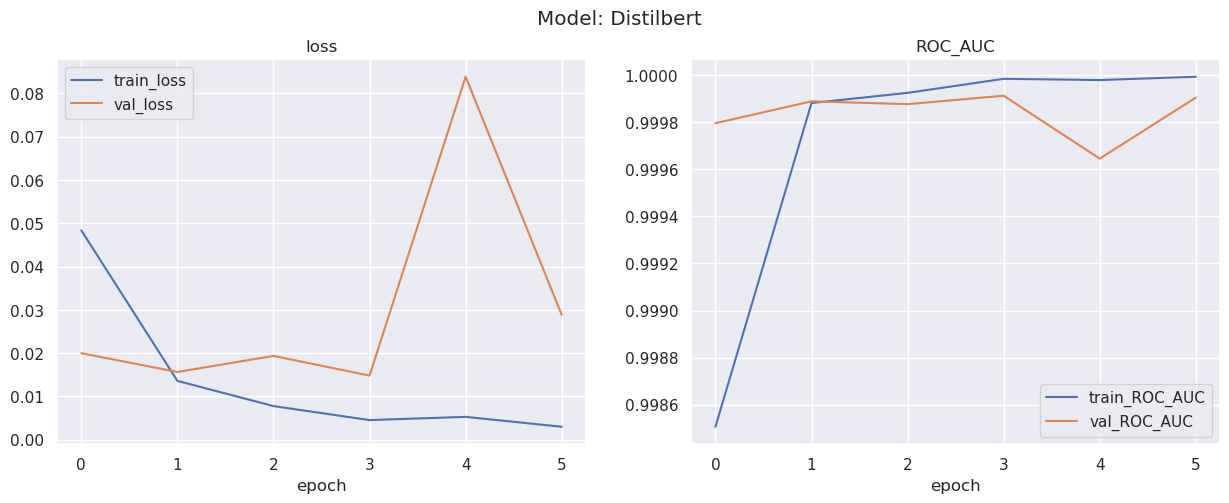

<IPython.core.display.Javascript object>

In [129]:
modeltrainer.plot_metrics(model_name, version, ["loss", "score"], ["loss", "ROC_AUC"])

The training loss is decreasing over epochs so the model is continuously learning from the new data. Moreover, the gap between training and validation ROC AUC values is relatively small which also indicates reasonable generalization. The best performing model is achieved after four epochs.

In [84]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
evaluation_ft = modeltrainer.evaluate(model_nn, model_name, validation_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [85]:
evaluation_ft["metrics"]

ROC AUC  Average Inference Time
model                                       
Distilbert  0.999982                0.054558

<IPython.core.display.Javascript object>

The performance improves from the clf head training.

#### 3.3.2 DistilBERT with regularization

Next, the a new classifier head is trained with deeper structure to improve the performance by adding more regularization to the model.

In [86]:
model_nn = modelclass.NewsClassifier(
    train_dataset,
    validation_dataset,
    test_dataset,
    arch="distilbert_reg",
    lr=2e-4,
    batch_size=32,
    backbone_tuning=False,
)
model_name = "Distilbert"
version = "clf_training_reg"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

For clf head training, the learning rate is selected with pytorch learning rate finder.

In [111]:
modeltrainer.train(
    model_nn,
    model_name,
    version,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---Currently Distilbert version clf_training_reg in training.---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 93 steps due to diverging loss.
Learning rate set to 0.002754228703338169
Restoring states from the checkpoint path at /home/jaakoiv/DeepLearning/.lr_find_36e30425-f3a4-4f5c-b184-9d5d5e6f20b7.ckpt
Restored all states from the checkpoint at /home/jaakoiv/DeepLearning/.lr_find_36e30425-f3a4-4f5c-b184-9d5d5e6f20b7.ckpt


---Selected starting learning rate: 0.002754228703338169---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                                | Params
----------------------------------------------------------------------
0 | train_score   | BinaryAUROC                         | 0     
1 | valid_score   | BinaryAUROC                         | 0     
2 | test_score    | BinaryAUROC                         | 0     
3 | model         | DistilBertForSequenceClassification | 67.5 M
4 | loss_function | BCEWithLogitsLoss                   | 0     
----------------------------------------------------------------------
1.2 M     Trainable params
66.4 M    Non-trainable params
67.5 M    Total params
270.179   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


<IPython.core.display.Javascript object>

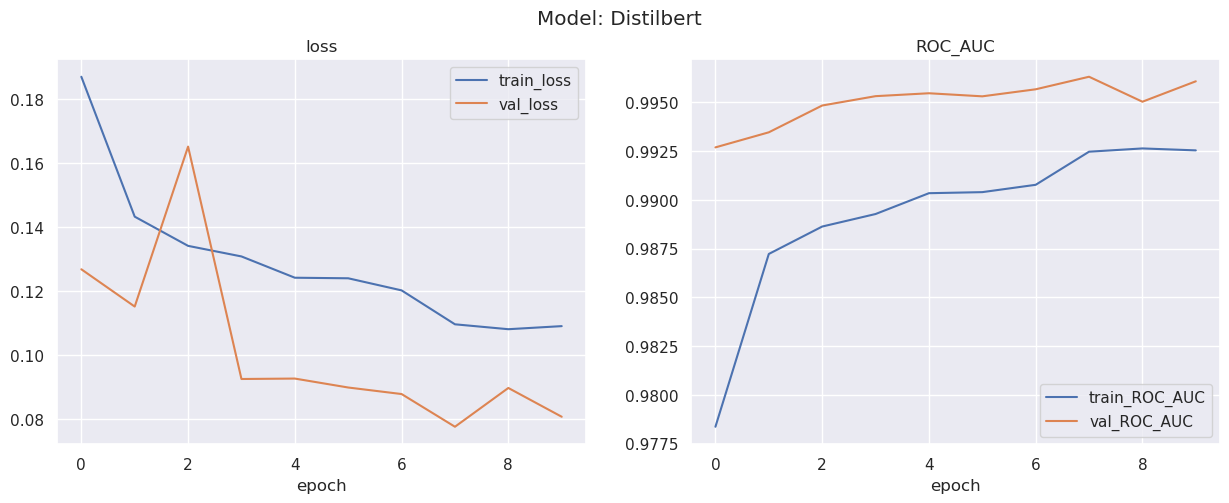

<IPython.core.display.Javascript object>

In [112]:
modeltrainer.plot_metrics(model_name, version, ["loss", "score"], ["loss", "ROC_AUC"])

The validation and training losses are decreasing over epochs so the model is continuously learning from the new data and generalizing well. Moreover, the gap between training and validation ROC AUC values is relatively small which also indicates reasonable generalization.

In [87]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
evaluation_clft_reg = modeltrainer.evaluate(model_nn, model_name, validation_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [88]:
evaluation_clft_reg["metrics"]

ROC AUC  Average Inference Time
model                                       
Distilbert  0.997131                0.045218

<IPython.core.display.Javascript object>

The performance improves from the first trained clf head. Next the backbone is unfreeze and fine-tuned together with the classifier head. 

In [89]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

In [90]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
model_nn.lr = 2e-5
model_nn.backbone_tuning = True
model_nn._base_grad(True, True)
model_name = "Distilbert"
version = "fine_tuning_reg"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [116]:
modeltrainer.train(model_nn, model_name, version, max_epochs=10, lr=model_nn.lr)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---Currently Distilbert version fine_tuning_reg in training.---
---Selected starting learning rate: 2e-05---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                                | Params
----------------------------------------------------------------------
0 | train_score   | BinaryAUROC                         | 0     
1 | valid_score   | BinaryAUROC                         | 0     
2 | test_score    | BinaryAUROC                         | 0     
3 | model         | DistilBertForSequenceClassification | 67.5 M
4 | loss_function | BCEWithLogitsLoss                   | 0     
----------------------------------------------------------------------
67.5 M    Trainable params
0         Non-trainable params
67.5 M    Total params
270.179   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

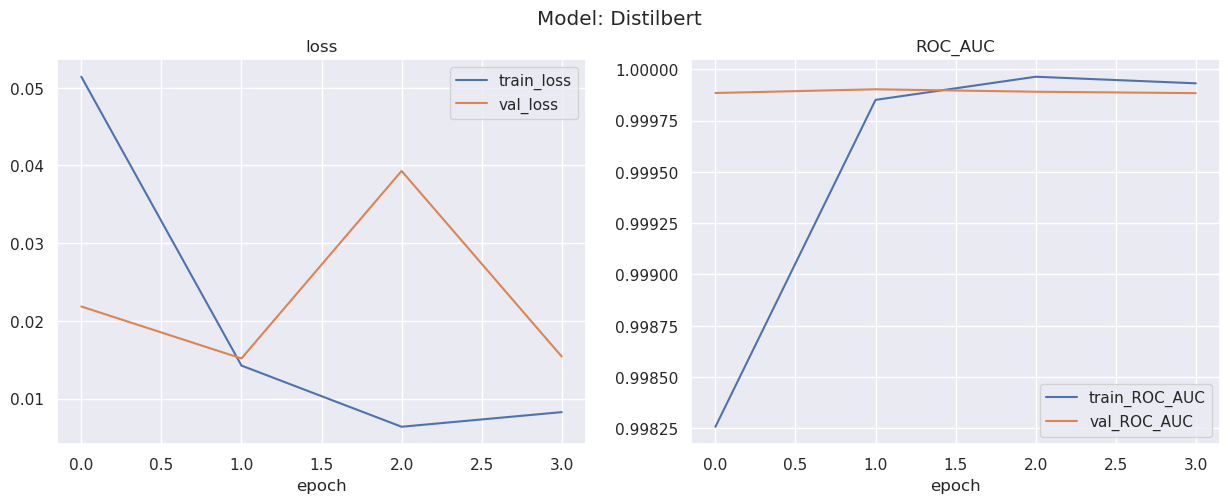

<IPython.core.display.Javascript object>

In [117]:
modeltrainer.plot_metrics(model_name, version, ["loss", "score"], ["loss", "ROC_AUC"])

The training loss is decreasing over epochs so the model is continuously learning from the new data. Moreover, the gap between training and validation ROC AUC values is relatively small which also indicates reasonable generalization. The best performing model is achieved after two epochs.

In [91]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
evaluation_ft_reg = modeltrainer.evaluate(model_nn, model_name, validation_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [92]:
evaluation_ft_reg["metrics"]

ROC AUC  Average Inference Time
model                                       
Distilbert  0.999969                0.050148

<IPython.core.display.Javascript object>

The performance improves from the classifier head training.

#### 3.3.3 DistilBERT with letter case

Final version of DistilBERT model is a classifier that is trained with intact letter case. The classifier head is the same as in the first version.

In [70]:
train_dataset_withcase = customdataset.CustomNewsDataset(df_train, lower_case=False)
validation_dataset_withcase = customdataset.CustomNewsDataset(df_val, lower_case=False)
test_dataset_withcase = customdataset.CustomNewsDataset(df_test, lower_case=False)

<IPython.core.display.Javascript object>

In [94]:
model_nn = modelclass.NewsClassifier(
    train_dataset_withcase,
    validation_dataset_withcase,
    test_dataset_withcase,
    lr=2e-4,
    batch_size=32,
    backbone_tuning=False,
)
model_name = "Distilbert_withcase"
version = "clf_training"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [694]:
modeltrainer.train(model_nn, model_name, version, max_epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---Currently Distilbert_withcase version clf_training in training.---


/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/Distilbert_withcase/clf_training exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottlene

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.002594307816257042
Restoring states from the checkpoint path at /home/jaakoiv/DeepLearning/.lr_find_6351cea1-c5c0-4fdb-adae-3e4b88890201.ckpt
Restored all states from the checkpoint at /home/jaakoiv/DeepLearning/.lr_find_6351cea1-c5c0-4fdb-adae-3e4b88890201.ckpt


---Selected starting learning rate: 0.002594307816257042---


/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jaakoiv/DeepLearning/logs/Distilbert_withcase/clf_training/best_ckpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                                | Params
----------------------------------------------------------------------
0 | train_score   | BinaryAUROC                         | 0     
1 | valid_score   | BinaryAUROC                         | 0     
2 | test_score    | BinaryAUROC                         | 0     
3 | model         | DistilBertForSequenceClassification | 67.0 M
4 | loss_function | BCEWithLogitsLoss                   | 0     
----------------------------------------------------------------------
591 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.817   Tot

Sanity Checking: 0it [00:00, ?it/s]

/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


<IPython.core.display.Javascript object>

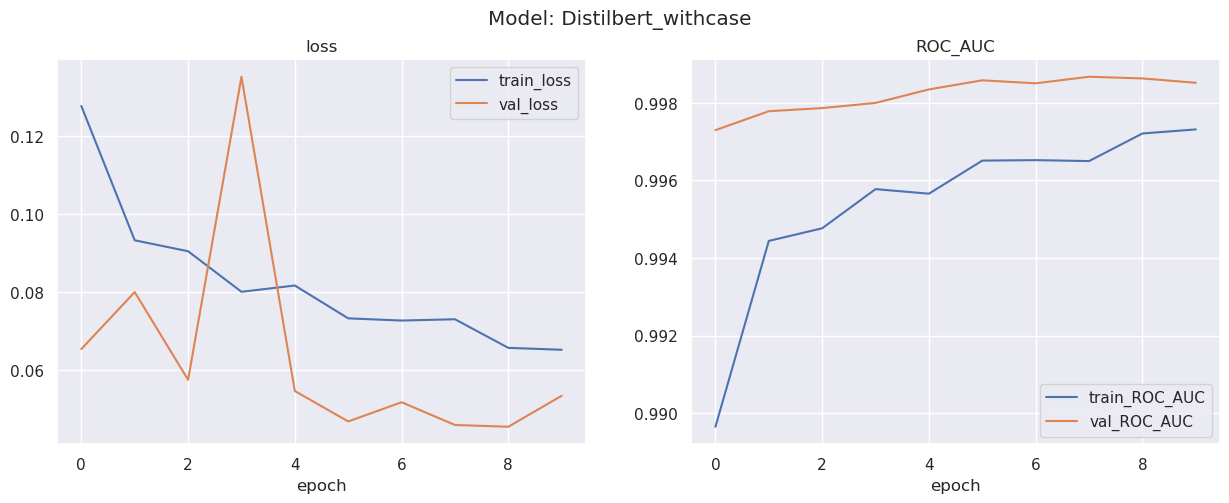

<IPython.core.display.Javascript object>

In [695]:
modeltrainer.plot_metrics(model_name, version, ["loss", "score"], ["loss", "ROC_AUC"])

The validation and training losses are decreasing over epochs so the model is continuously learning from the new data and generalizing well. Moreover, the gap between training and validation ROC AUC values is relatively small which also indicates reasonable generalization.

In [95]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
evaluation_clft_withcase = modeltrainer.evaluate(
    model_nn, model_name, validation_dataset_withcase
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [96]:
evaluation_clft_withcase["metrics"]

ROC AUC  Average Inference Time
model                                               
Distilbert_withcase   0.9987                0.046215

<IPython.core.display.Javascript object>

Next the backbone is unfreeze and fine-tuned together with the classifier head.

In [97]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

In [73]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
model_nn.lr = 2e-5
model_nn.backbone_tuning = True
model_nn._base_grad(True, True)
model_name = "Distilbert_withcase"
version = "fine_tuning"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [74]:
modeltrainer.train(model_nn, model_name, version, max_epochs=10, lr=model_nn.lr)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---Currently Distilbert_withcase version fine_tuning in training.---
---Selected starting learning rate: 2e-05---


/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/Distilbert_withcase/fine_tuning exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/jaakoiv/DeepLearning/logs/Distilbert_withcase/fine_tuning/best_ckpt exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                                | Params
----------------------------------------------------------------------
0 | train_score   | BinaryAUROC                         | 0     
1 | valid_score   | BinaryAUROC                         | 0     
2 | test_score    | BinaryAUROC                    

Sanity Checking: 0it [00:00, ?it/s]

/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jaakoiv/miniconda3/envs/md4_cp1/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

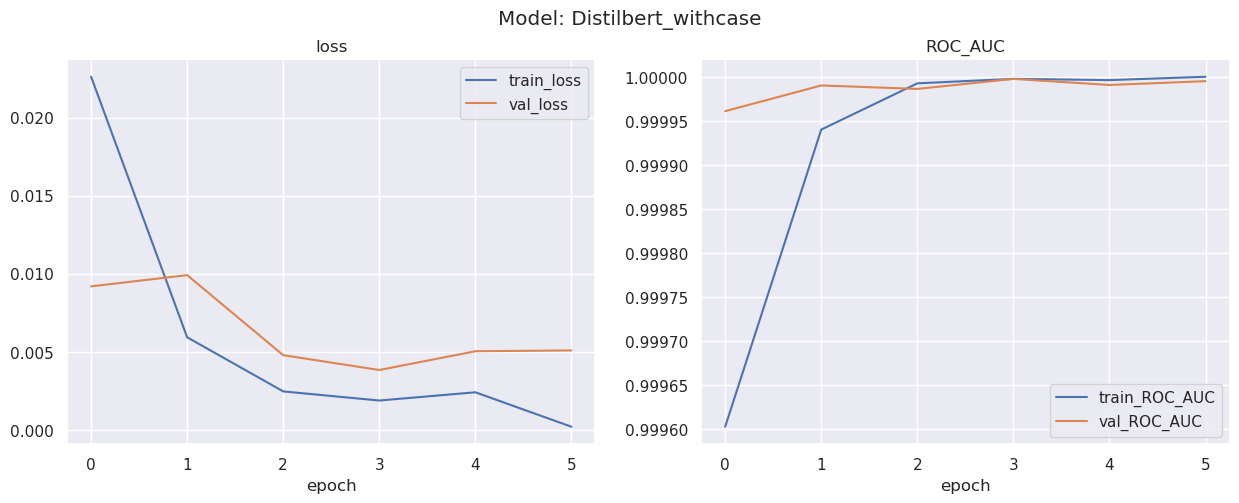

<IPython.core.display.Javascript object>

In [75]:
modeltrainer.plot_metrics(model_name, version, ["loss", "score"], ["loss", "ROC_AUC"])

The training loss is decreasing over epochs so the model is continuously learning from the new data. Moreover, the gap between training and validation ROC AUC values is relatively small which also indicates reasonable generalization. The best performing model is achieved after four epochs.

In [98]:
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
evaluation_ft_withcase = modeltrainer.evaluate(
    model_nn, model_name, validation_dataset_withcase
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [99]:
evaluation_ft_withcase["metrics"]

ROC AUC  Average Inference Time
model                                               
Distilbert_withcase   0.9987                0.048779

<IPython.core.display.Javascript object>

### 3.4 Comparison of model performances

Next, all the models are compared and the best model is selected for final model assessment. The inference times for the heuristic model and ML models are set to zero as they are smaller than one millisecond.

In [100]:
models_to_evaluate = (
    ("Base score", ""),
    ("logres", models["logres"]),
    ("randomforest", models["randomforest"]),
    ("catboost", models["catboost"]),
    ("DistilBERT_clf_trained", evaluation_clft),
    ("DistilBERT_clf_trained_w_reg", evaluation_clft_reg),
    ("DistilBERT_clf_trained_wcase", evaluation_clft_withcase),
    ("DistilBERT_fine_tuned", evaluation_ft),
    ("DistilBERT_fine_tuned_w_reg", evaluation_ft_reg),
    ("DistilBERT_fine_tuned_wcase", evaluation_ft_withcase),
)

<IPython.core.display.Javascript object>

In [101]:
results_df = pd.DataFrame(columns=["Model", "F1 Score", "ROC AUC", "Inference time"])

for model_name, model_obj in models_to_evaluate:
    if model_name == "Base score":
        f1 = f1_score(df_val["target"], df_val["predicted"], average="macro")
        roc_auc = 0.5
        inference_time = 0
    elif "DistilBERT" in model_name:
        labels = model_obj["true_labels"]["label"]
        proba = model_obj["predictions"]["proba"]
        predictions = model_obj["predictions"]["label"]
        f1 = f1_score(labels, predictions, average="macro")
        roc_auc = roc_auc_score(labels, proba)
        inference_time = model_obj["metrics"]["Average Inference Time"].item()
    else:
        predictions = model_obj.predict(X_val)
        proba = model_obj.predict_proba(X_val)[:, 1]
        f1 = f1_score(y_val, predictions, average="macro")
        roc_auc = roc_auc_score(y_val, proba)
        inference_time = 0

    temp_df = pd.DataFrame(
        {
            "Model": [model_name],
            "F1 Score": [f1],
            "ROC AUC": [roc_auc],
            "Inference time": [inference_time],
        }
    )
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

<IPython.core.display.Javascript object>

In [102]:
results_df

Model  F1 Score   ROC AUC Inference time
0                    Base score  0.781913  0.500000              0
1                        logres  0.926296  0.971481              0
2                  randomforest  0.928808  0.978037              0
3                      catboost  0.943551  0.985857              0
4        DistilBERT_clf_trained  0.975152  0.996955       0.044962
5  DistilBERT_clf_trained_w_reg  0.975327  0.997131       0.045218
6  DistilBERT_clf_trained_wcase  0.986282  0.998700       0.046215
7         DistilBERT_fine_tuned  0.996478  0.999982       0.054558
8   DistilBERT_fine_tuned_w_reg  0.997711  0.999969       0.050148
9   DistilBERT_fine_tuned_wcase  0.986282  0.998700       0.048779

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Comparison of model performance')

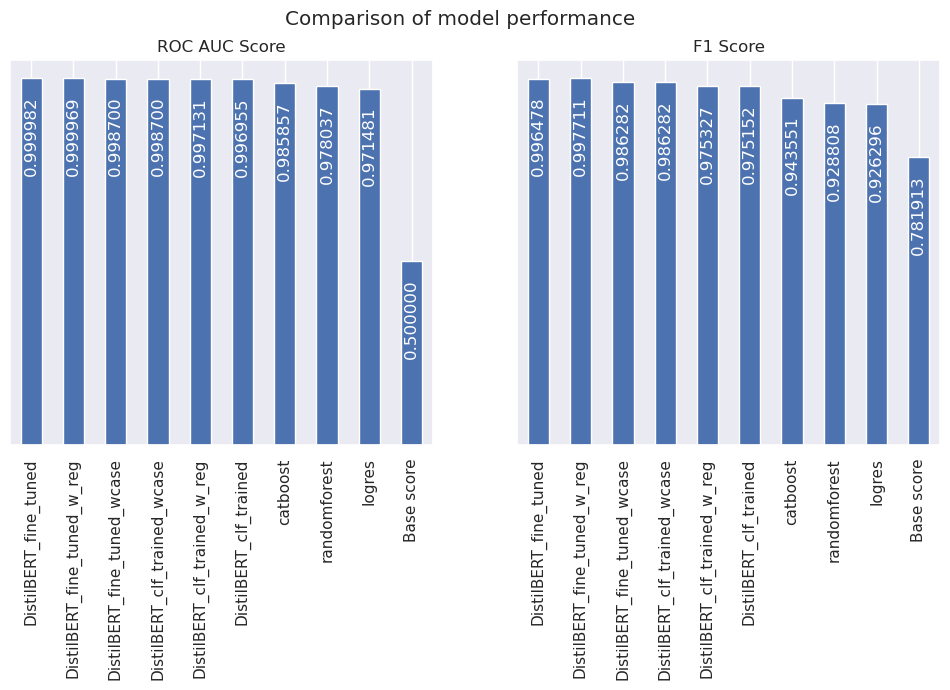

<IPython.core.display.Javascript object>

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
results_df.sort_values(by="ROC AUC", inplace=True, ascending=False)
results_df.plot.bar(x="Model", y="ROC AUC", ax=axes[0], title="ROC AUC Score")
results_df.plot.bar(x="Model", y="F1 Score", ax=axes[1], title="F1 Score")
for ax in axes:
    ax.legend([]).set_visible(False)
    for container in ax.containers:
        ax.bar_label(
            container,
            padding=-70,
            color="white",
            fmt="{:.6f}",
            fontsize=12,
            rotation=90,
        )
    ax.set_yticks([])
    ax.set_xlabel("")
fig.suptitle("Comparison of model performance")

All models exceed the F1 base score. The DistilBERT model with simpler classifier head, lower case input text, and the whole model tuning performs the best based on the ROC AUC score. The model’s inference time is significantly higher than the ML models but it is still rather small. 

The DistilBERT model is selected for final assessment as it only classifies the news articles based on the text. Using engineered features may have limitations and miss some nuances or more complex patterns from the data. In this project as the performance of all the models is very high, these small nuances are important to capture.

### 3.5 Final model assessment

Here the final model performance is evaluated with test dataset.

In [132]:
model_nn = modelclass.NewsClassifier(
    train_dataset,
    validation_dataset,
    test_dataset,
    lr=2e-4,
    batch_size=32,
    backbone_tuning=True,
)
model_name = "Distilbert"
version = "fine_tuning"
path = f"logs/{model_name}/{version}/best_ckpt"
all_files = glob.glob(os.path.join(path, "*.ckpt"))
newest_file = max(all_files, key=os.path.getctime)

model_nn = model_nn.load_from_checkpoint(newest_file)
evaluation = modeltrainer.evaluate(model_nn, model_name, test_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [133]:
evaluation["metrics"]

ROC AUC  Average Inference Time
model                                       
Distilbert  0.999978                0.049164

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

        real     0.9955    0.9997    0.9976      3116
        fake     0.9996    0.9946    0.9971      2609

    accuracy                         0.9974      5725
   macro avg     0.9976    0.9972    0.9974      5725
weighted avg     0.9974    0.9974    0.9974      5725



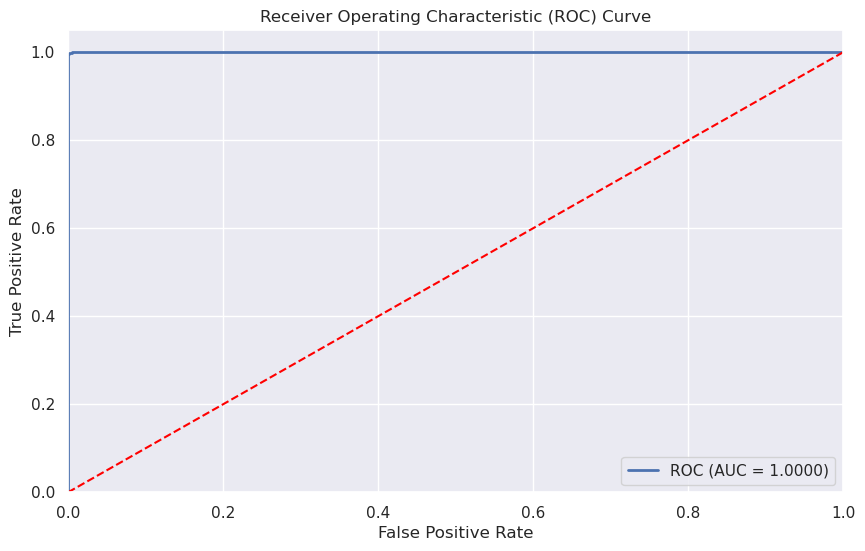

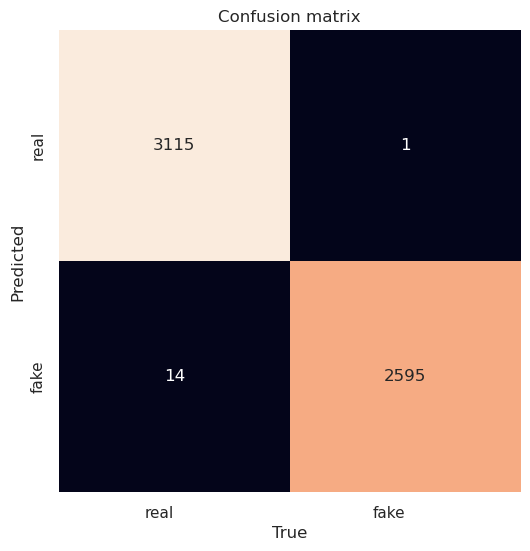

<IPython.core.display.Javascript object>

In [135]:
postprocessingtools.metrics(
    evaluation["true_labels"]["label"],
    evaluation["predictions"]["label"],
    evaluation["predictions"]["proba"],
    label_names=["real", "fake"],
    plot=True,
)

The model performance results against test data are similar with validation data. The performance is exceptionally high, especially ROC AUC value.  The model predicts both classes similarly so there is no need for probability threshold optimization. 

Even though after thorough EDA and identifying and removing data leakages, the model performance is uncommonly high. This leaves room for speculation for what are causing this high performance metrics. 
- The dataset characteristics can be so that there are easily identified patterns for fake and real news which led to very high model performance. This is also seen with the simple heuristic model that had the F1-score of 0.79.
- The simplicity of the classification task is justified with the effect of the engineered features. These features are the core of the heuristic model, and they give the most essential information to the ML models to make the classification decisions. 

#### 3.5.1 Model interpretability and mislabeled cases
Next, the model performance for the mislabeled cases is investigated. The worst cases are defined to be the cases with largest deviation from the true labels values.

In [136]:
results_df = pd.DataFrame()
results_df["predicted_label"] = evaluation["predictions"]["label"]
results_df["probability"] = evaluation["predictions"]["proba"]
results_df["input_ids"] = evaluation["true_labels"]["input_ids"]
results_df["true_label"] = evaluation["true_labels"]["label"]
results_df["error"] = np.abs(results_df["probability"] - results_df["true_label"])

<IPython.core.display.Javascript object>

In [137]:
worst_cases = results_df.sort_values(by="error", ascending=False).iloc[:3, :]

<IPython.core.display.Javascript object>

In [143]:
for i in range(worst_cases.shape[0]):
    print("--------------------")
    print(f"True label: {map_target[worst_cases.iloc[i,:].true_label]}")
    print(f"Predicted label: {map_target[worst_cases.iloc[i,:].predicted_label]}")
    print(f"Predicted probability: {worst_cases.iloc[i,:].probability:.2%}")
    print(f"Error: {worst_cases.iloc[i,:].error:.5f}")
    print(test_dataset.decode(worst_cases.iloc[i, :]["input_ids"]))

--------------------
True label: fake
Predicted label: real
Predicted probability: 0.00%
Error: 0.99997
gunfight erupts muslim migrants fight to keep minority christians out of camp in northern france muslims want the majority christian nations to accept them and pay for their existence but will stop at nothing to keep the christian refugees from staying in camps that are funded by the host nations a gunfight has erupted in a migrant camp in northern france leaving four people wounded after clashes that were thought to have involved rival gangs of smugglerstwo men were treated overnight for gunshot wounds a third for stab wounds and a woman for blows to the head following the clashes at the grandesynthe camp near dunkirkfour people were held for questioning on charges of
--------------------
True label: fake
Predicted label: real
Predicted probability: 2.15%
Error: 0.97846
breaking reportedly considering ted cruz for top cabinet position ted cruz would be fair honest and most of all he

<IPython.core.display.Javascript object>

In [161]:
def find_title(substring, row):
    if substring in row["title"].lower():
        return 1
    else:
        return row["match"]


df_test["match"] = 0
for t in ["gunfight erupts", "ted cruz for top cabinet position", "old haiti official"]:
    find_title_p = partial(find_title, t)
    df_test["match"] = df_test.apply(lambda x: find_title_p(x), axis=1)
df_test.loc[df_test["match"] == 1, "title"]

12384                                                                     BREAKING  Reportedly Considering Ted Cruz For Top Cabinet Position
21059                                       GUNFIGHT ERUPTS Muslim Migrants Fight To Keep Minority Christians Out Of Camp in Northern France
10385     OLD HAITI OFFICIAL Slated To Testify Against Clinton Foundation Corruption Next Week Found DEAD In Miami With Gunshot to the head 
Name: title, dtype: object

<IPython.core.display.Javascript object>

In [162]:
for idx, row in df_test.loc[df_test["match"] == 1].iterrows():
    sample_text = row["title"] + " " + row["text"]
    print(f"True label: {map_target[row.target]}")
    postprocessingtools.show_lime_explainer(
        model_nn,
        sample_text,
        postprocessingtools.distilbert_predictor,
        class_names=["real", "fake"],
    )

True label: fake


True label: fake


True label: fake


<IPython.core.display.Javascript object>

Here is the LIME results for the worst predicted cases. 

For these cases we can see that the model mislabels cases more easily if the used vocabulary is more close a real-world news event involving mentions of specific locations, authorities and weekdays. Similarly, mentions of 'muslims', Hillary Clinton, more dramatic vocabulary, e.g. 'breaking' model interprets to indicate fake news. However, in these cases, the real news indicators are much stronger compared to the fake news indicators which is why the model mislabels the news.

***

## 4. Conclusion

A data analysis is conducted for fake-real news dataset.  The main purpose of this analysis is to train a fake news classifier.

The main research questions are:
- What is the target label distribution?
- What is the title and text word count distribution?
- What are the most important features to predict target label?
- Create a heuristic rule to set a baseline for the models. 
- Is there enough data to create a well performing classifier?

Based on the exploratory analysis it can conclude that 
- The target distribution is well balanced, but there are several data leakages that are removed from the dataset.
	- date column
	- subject column
	- 'Reuters' tag in the start of a real news text
	- duplicate data instances
- The analysis revealed that fake news has generally longer titles. The word count in text is not that different between the target labels.
- The most important features to predict target labels are title word count, number of uppercase words in titles and certain words in the article text, e.g. video.
- A heuristic model is created that uses title uppercase word count and title word count to determine if the news is real or fake.  Performance for this model is:
	- 0.792 accuracy
	- 0.791 F1-score 

Based on the model training it can conclude that
-	The dataset is rather easy to predict even after removing data leakages and most frequent words. This makes the risk of overfitting greater.
-	ML models showed similar findings in the feature importance analysis as in EDA.
-	There is enough data to train well performing classifier.
-	A DistilBERT classifier with excellent performance is trained.
	-	0.997 accuracy
	-	0.997 f1-score


#### Future remarks
- For machine learning models, more in-depth hyperparameter tuning, especially for regulative parameters could improve the performance.
- For Neural Network, more thorough hyperparameter tuning especially for regulative parameter could improve the performance.
- Sensitivity analysis in EDA and use it as feature for ML models.
